In [4]:
import glob 
import numpy as np
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pylab as plt
import datetime
from scipy.signal import butter, welch, filtfilt, periodogram, savgol_filter
import time
import pandas as pd
import sys
import os
import re

sys.path.append('/usr/local/src/pysmurf/scratch/smithzj/')
os.chdir('/usr/local/src/pysmurf/scratch/smithzj/')

from utils.ResonanceFitter import finefit,resfunc3
from utils.mems_data_collection_utils import rotate_to_ideal_compact, rotate_to_ideal_semi_compact, resonator_basis, get_freq_in_Hz
from utils.mems_data_collection_utils import load_tune_file, fit_tune_file, fit_data, plot_fit
from utils.mems_data_collection_utils import slowInitializeMkidSmurf, takeDebugData_new, logDebugData, loadDebugData


/usr/local/src/pysmurf/scratch/smithzj


In [5]:
import pysmurf.client
import matplotlib.pylab as plt
%matplotlib inline  

In [2]:


epics_prefix="smurf_server_s3"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/stanford/experiment_fp31_cc03-02_lbOnlyBay0.cfg")
## going to run setup just this time
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=True,make_logfile=True,shelf_manager="shm-smrf-sp01")
logfile = S.log.logfile.name

In [3]:
print(logfile)
print('Pysmurf Client Version:',pysmurf.__version__)


/data/smurf_data/20250626/1750957495/outputs/1750957495.log
Pysmurf Client Version: 8.0.0-rc3+12.gc1067044.dirty


In [4]:
S.which_on(2)

array([66])

Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function set_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function set_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping ca

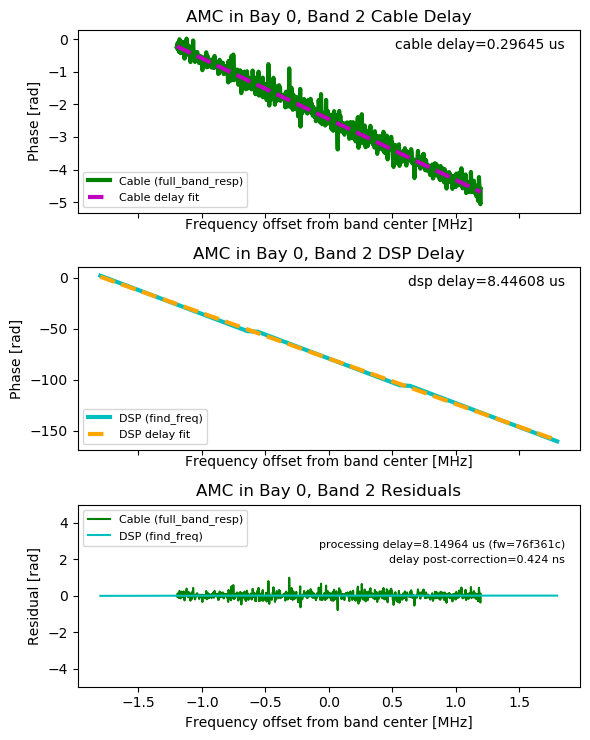

(8.446082902142221, 0.0004239868729839709)

In [5]:
S.estimate_phase_delay(2,freq_min=-1200000,freq_max=1200000)

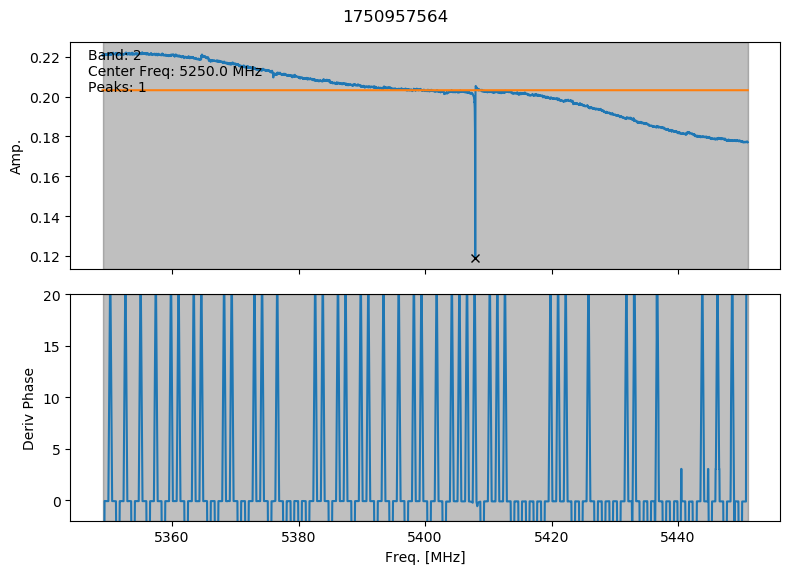

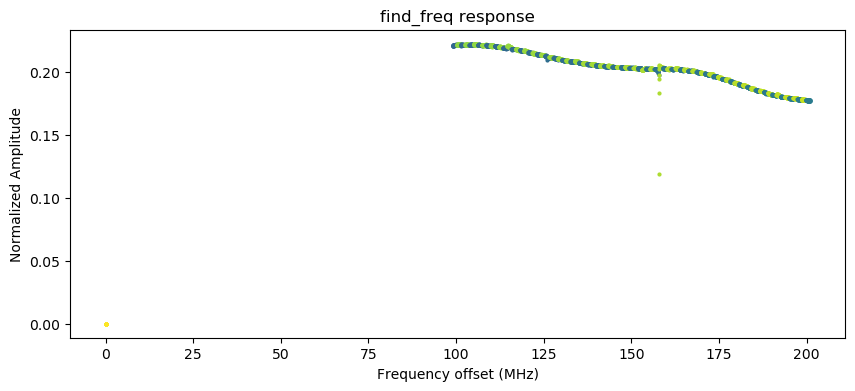

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [6]:

S.find_freq(2,tone_power=14,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9, rolling_med=False) #amp cut decides what you count for a resonator 

In [7]:
def TESTlogDebugData(S, band, reschannel, nsamp, sync, filename, tunefile, cooldown_str, decimation, filter_f3db, channel_mode, char_avgs={}, awg_settings={}, led_settings={}, MEMS_settings={}, rf_settings={}, fit_dict={},temp=0):
    freq_in_Hz = get_freq_in_Hz(S, band=band, channel=reschannel) 
    eta_phase_degree = S.get_eta_phase_degree_channel(band,reschannel)
    eta_phase_rad = np.deg2rad(eta_phase_degree)
    fs = S.get_channel_frequency_mhz(band) * 1.0E6 * (channel_mode)/2 / (decimation+1)
    att_uc = S.get_att_uc(band)
    att_dc = S.get_att_dc(band)    

            
    amplitude_scale_array = S.get_amplitude_scale_array(band).tolist()
    channels = []
    for i in range(len(amplitude_scale_array)):
        if amplitude_scale_array[i] != 0:
            channels.append(i)
    data_dict = {}
    data_dict['band'] = band
    data_dict['channels'] = channels
    data_dict['filename'] = filename
    data_dict['nsamp'] = nsamp
    data_dict['freq_in_Hz'] = freq_in_Hz
    data_dict['eta_phase_rad'] = eta_phase_rad.tolist()
    data_dict['fs'] = fs
    data_dict['decimation'] = decimation
    data_dict['channel_mode'] = channel_mode
    data_dict['filter_f3db'] = filter_f3db
    data_dict['amplitude_scale_array'] = amplitude_scale_array
    data_dict['att_uc'] = att_uc
    data_dict['att_dc'] = att_dc
    data_dict['tunefile']=tunefile
    data_dict['awg_settings']=awg_settings
    data_dict['char_avgs']= char_avgs
    data_dict['cooldown_str']= cooldown_str
    data_dict['MEMS'] = MEMS_settings
    data_dict['led_settings'] = led_settings
    data_dict['rf_settings'] = rf_settings
    data_dict['fit_dict'] = str(fit_dict)
    data_dict['temp_K'] = temp
    S.log("JSON DICT FOR " + filename)
    S.log(json.dumps(data_dict))

In [9]:
BAND = 2

/data/smurf_data/20250626/1750957495/outputs/1750957495.log


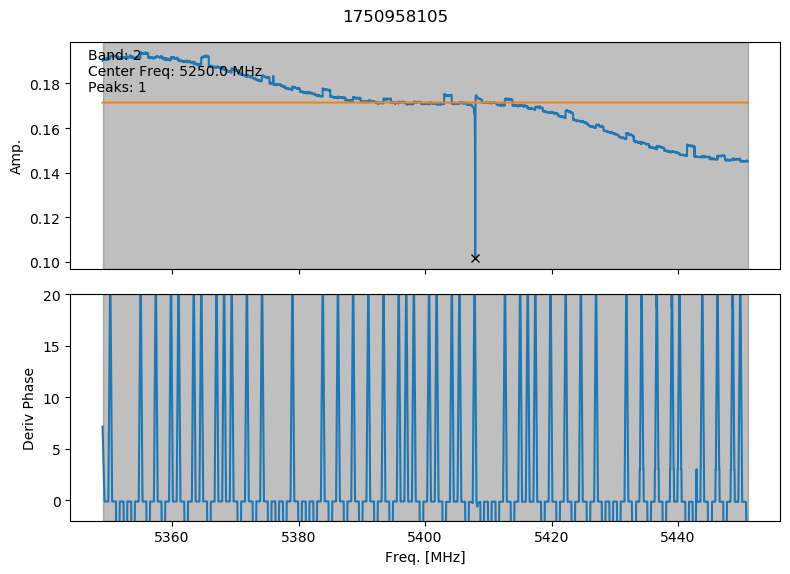

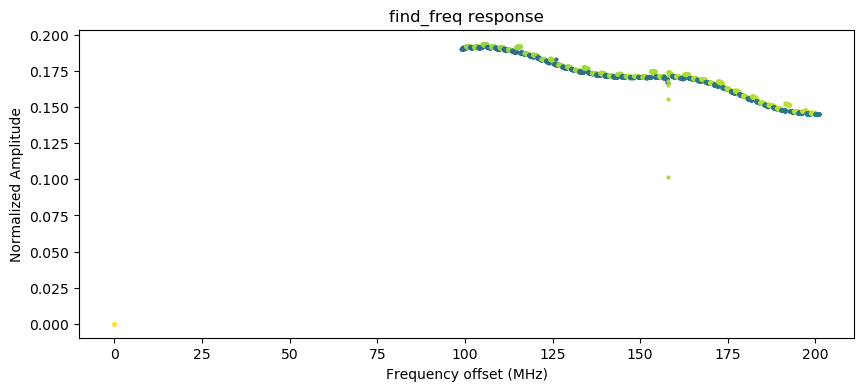

/data/smurf_data/tune/1750958116_tune.npy
Fr from fit  [GHz]: 5407.921667800812
Fr min curve [GHz]: 5407.9185
Fit dictionary parameters:   {'f0': 5407.921667800812, 'Qr': 161566.70923213282, 'phi': -0.30480213148502544, 'zOff': (-0.12866058017160611-0.154765867332554j), 'QcHat': 374169.62405435095, 'tau': (0.003931884362428797+0.004658447137772119j), 'Qc': 392249.85040682013}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


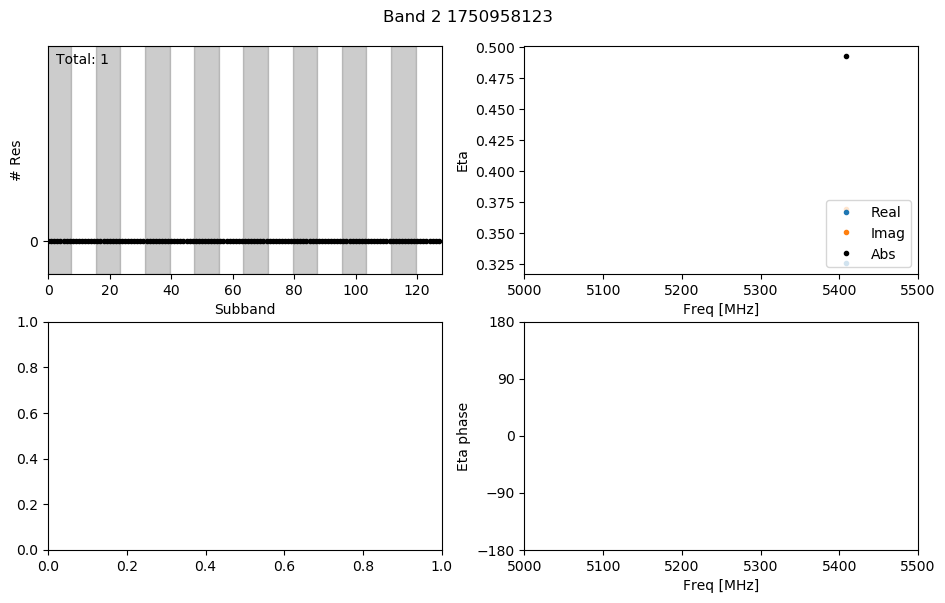

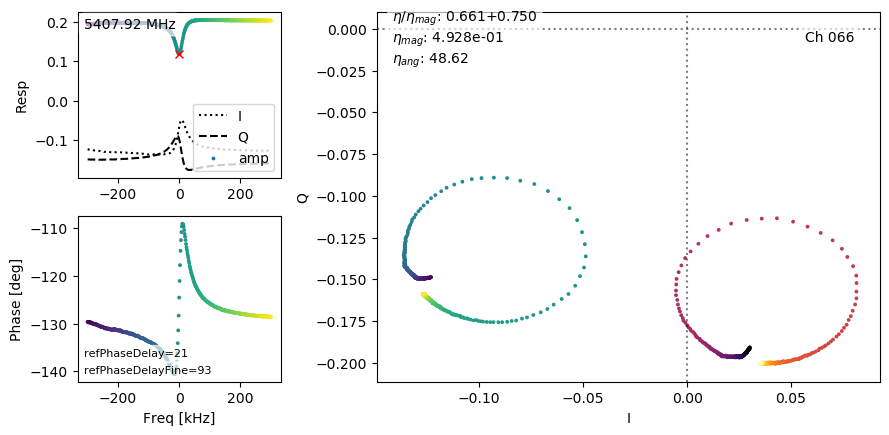

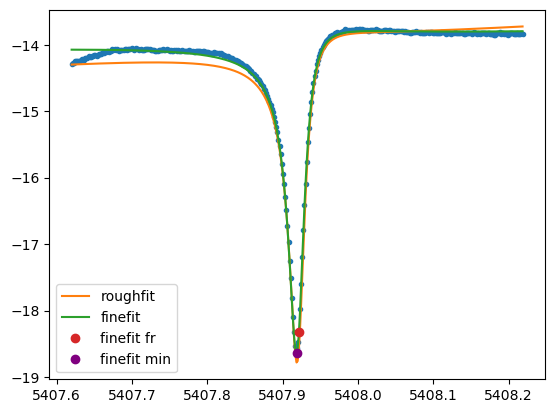

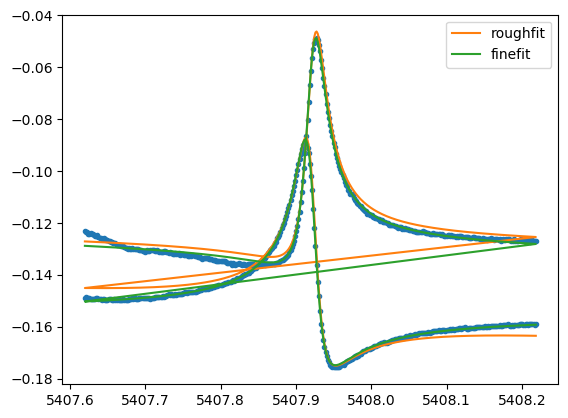

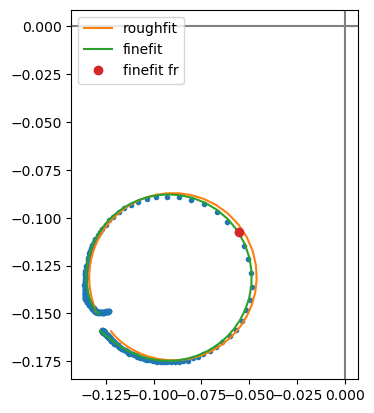

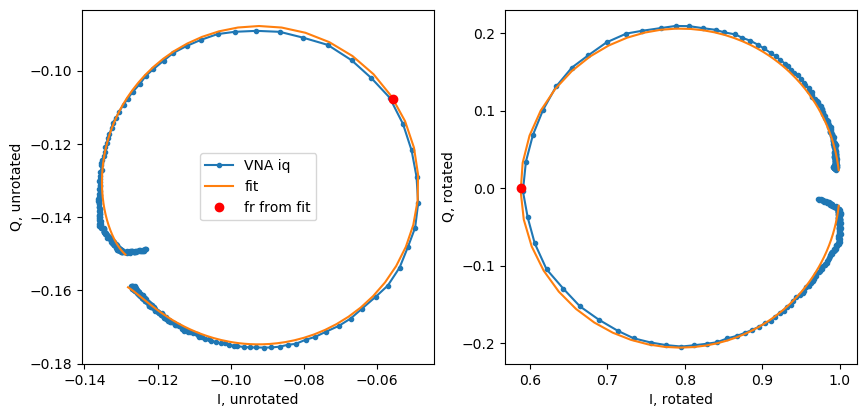

TIME: 1750958128
running char tones
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!


In [15]:

print( S.log.logfile.name)
TONE_POWER = 14

CH_GUESS = 66

NSAMP = 2**25

CHAN_MODE  = 2

NSAMP_CHAR = 2**15

CHAR_OFFSETS = [-0.2, -.1, 0, .1, 0.2]


ITERATIONS = 1

COOLDOWN = 'Olaf18'

DECIMATION = 0
FILTER_CUTOFF=2.4e6

F_OFF_RES = 5415 


LED_settings = {}


RF_settings = {'chain': ['Smurf out',\
               'LNF-LNR1_15B_SV',\
               '28 dB',\
               'C0', COOLDOWN, 'A2',\
               'ZX60-05113LN+',\
               '10 dB',\
               'ZX60-83LN-S+',\
               'Smurf in']}


AWG_settings = {}



## decide on decimation and filtering

S.find_freq(2,tone_power=13,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)
print(S.tune_file)

tune_dict=load_tune_file(S.tune_file, BAND)


S.set_feedback_enable_channel(BAND,CH_GUESS,0)
    
for ch in S.which_on(BAND):
    S.channel_off(BAND, ch)
    
    
fit_dict, fine_errs = fit_data(S.tune_file, BAND, plot=True)
char_offset_scale = fit_dict['f0'] / fit_dict['Qr'] 

plt.show()



#S.set_decimation(BAND, DECIMATION)
#S.set_debug_data_filter_cutoff(BAND, FILTER_CUTOFF)


file_list = []
MEMS_settings = {'mirror_position':[0,0], 'mirror_params':(90, 169, 120)}
    
for ii in range(ITERATIONS):
    print('TIME:', S.get_timestamp())    
    char_avgs = {}
    print('running char tones')
    for f_offs in CHAR_OFFSETS:
        new_freq = fit_dict['f0'] + char_offset_scale * f_offs 
        S.set_fixed_tone(new_freq, TONE_POWER)
        timestamp = S.get_timestamp() 
        channel = S.which_on(BAND)[0]
        filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
        i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP_CHAR,filename=filename, single_channel_readout=CHAN_MODE)
        avg = np.mean(i+1j*q)
        char_avgs[new_freq] = [avg.real, avg.imag]
        for ch in S.which_on(BAND):
            S.channel_off(BAND, ch)


   


    print('taking real data')
    S.set_fixed_tone(fit_dict['f0'], TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    

    print('taking real data')
    S.set_fixed_tone(F_OFF_RES, TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    


In [16]:
print(f"logfile = '{S.log.logfile.name}'")
print(f"directory_path = '{'/'.join(S.log.logfile.name.split('/')[0:-1])}/'")
print(f"rfsoc_tune_file = '{S.tune_file}'")
print('rfsoc_file_list = ',file_list)

logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1750958116_tune.npy'
rfsoc_file_list =  ['1750958140_single_channel_b2ch066', '1750958164_single_channel_b2ch290']


In [13]:
import json

In [133]:
BAND  = 2 

In [ ]:
1. Figure out if you are at the SAME readout powers (use amplitudes of off resonant tones) 
2. Figure out if Q's are teh same 
2. f

[-5.09572915 -4.92862576 -5.22151851 ... -4.9676485  -4.89849353
 -4.97323543]
[-0.84672915 -0.97062957 -0.84668999 ... -0.77279863 -0.79687468
 -0.82808506]
[-18.20224272 -18.19285092 -18.1306489  ... -18.19941536 -18.01988211
 -18.05841452]
[-14.0332415  -14.01767541 -14.07428423 ... -13.87734094 -13.91825089
 -13.99491862]


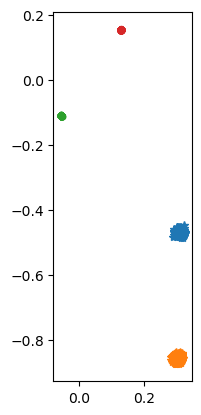

In [32]:
# these files are from the crate :
logfile_crate = '/data/smurf_data/20250624/1750806949/outputs/1750806949.log'
directory_path_crate = '/data/smurf_data/20250624/1750806949/outputs/'
crate_tune_file = '/data/smurf_data/tune/1750808478_tune.npy'
crate_file_list =  ['1750808504_single_channel_b2ch066', '1750808528_single_channel_b2ch290']

# these files are from the rfsoc: 
logfile_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1750958116_tune.npy'
rfsoc_file_list =  ['1750958140_single_channel_b2ch066', '1750958164_single_channel_b2ch290']

# now load them all, and make them 

# plot tune file 
for file in crate_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_crate+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='*', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(power_db)


for file in rfsoc_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='.', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(power_db)

plt.gca().set_aspect('equal')



In [30]:
print(0.8259227419109274 - 0.04018428681748533)
print(0.3157309997131494 - 0.015293226763054802)


0.7857384550934421
0.3004377729500946


In [18]:
30 * 25.71 / 1000

0.7713000000000001

/data/smurf_data/20250626/1750957495/outputs/1750957495.log


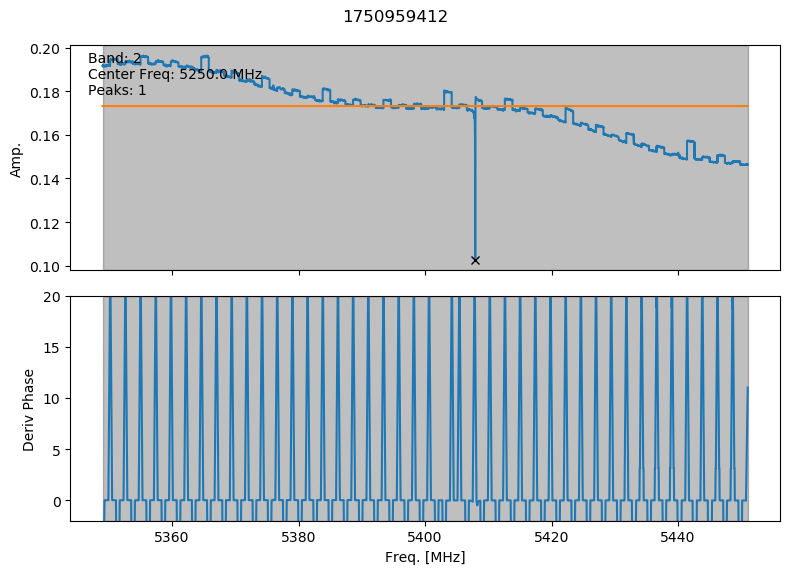

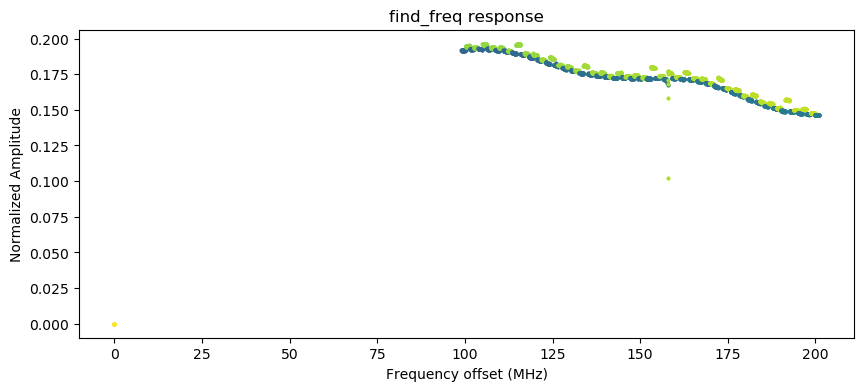

/data/smurf_data/tune/1750959423_tune.npy
Fr from fit  [GHz]: 5407.921500517359
Fr min curve [GHz]: 5407.9185
Fit dictionary parameters:   {'f0': 5407.921500517359, 'Qr': 161110.3199815727, 'phi': -0.30726806008908114, 'zOff': (-0.13952218331601-0.1585990223039354j), 'QcHat': 373714.19269489706, 'tau': (0.0036476627893051077+0.004919617752012164j), 'Qc': 392077.7760557431}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


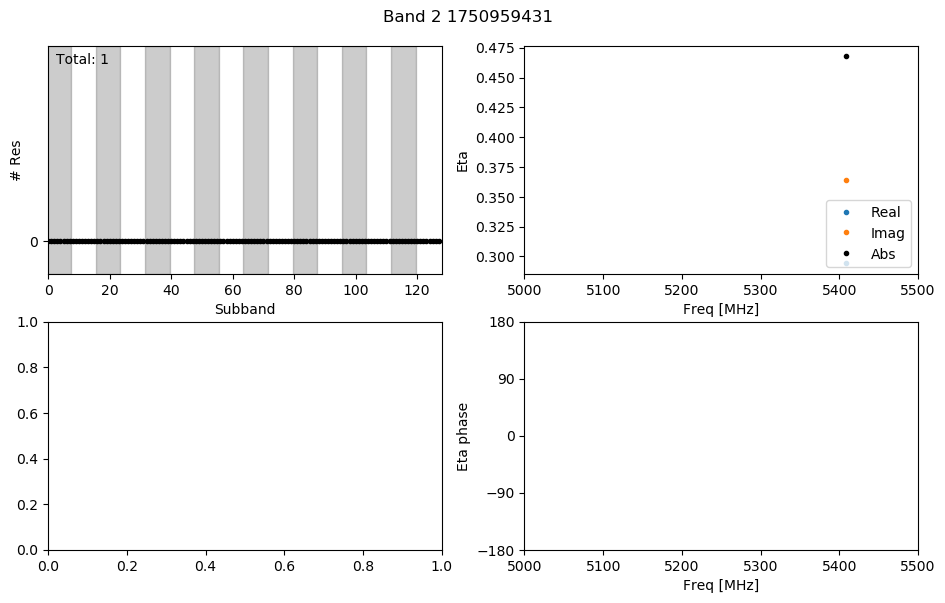

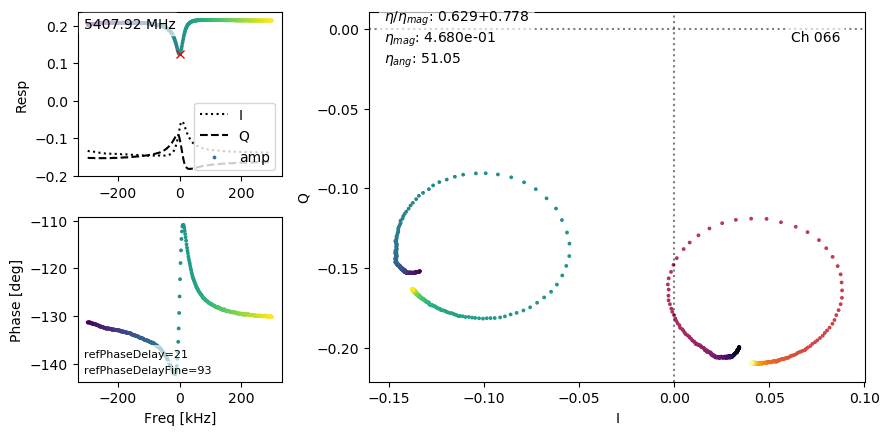

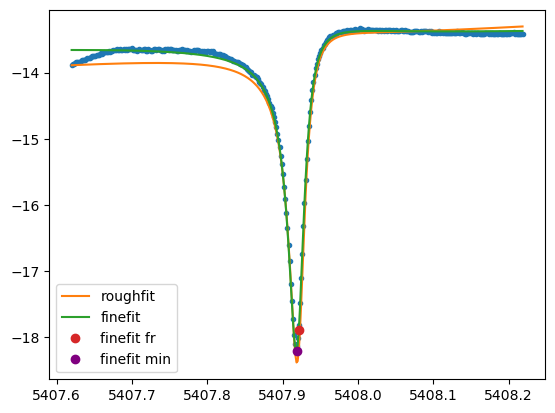

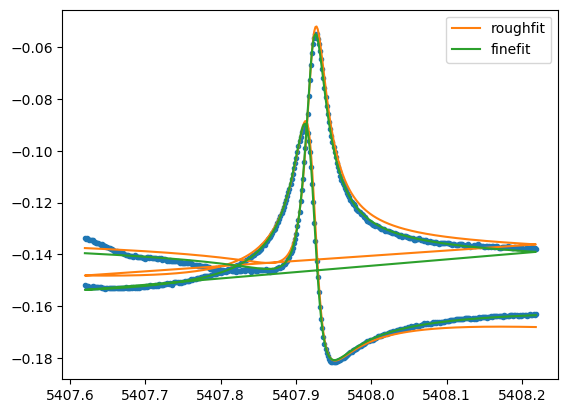

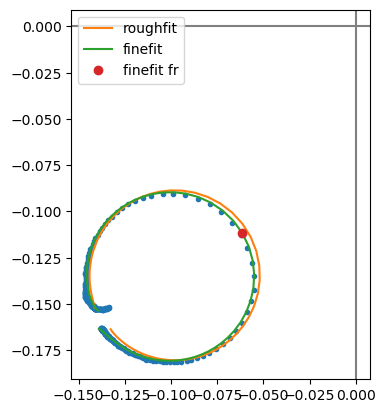

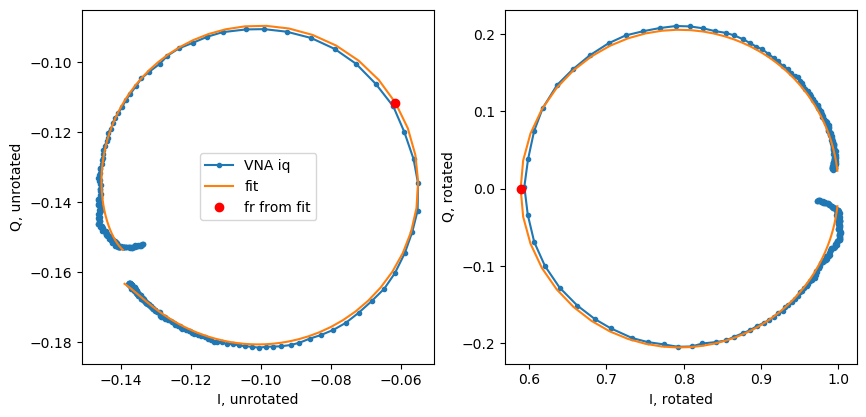

TIME: 1750959436
running char tones
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!


In [31]:

print( S.log.logfile.name)
TONE_POWER = 15

CH_GUESS = 66

NSAMP = 2**25

CHAN_MODE  = 2

NSAMP_CHAR = 2**15

CHAR_OFFSETS = [-0.2, -.1, 0, .1, 0.2]


ITERATIONS = 1

COOLDOWN = 'Olaf18'

DECIMATION = 0
FILTER_CUTOFF=2.4e6

F_OFF_RES = 5415 


LED_settings = {}


RF_settings = {'chain': ['Smurf out',\
               'LNF-LNR1_15B_SV',\
               '28 dB',\
               'C0', COOLDOWN, 'A2',\
               'ZX60-05113LN+',\
               '10 dB',\
               'ZX60-83LN-S+',\
               'Smurf in']}


AWG_settings = {}



## decide on decimation and filtering

S.find_freq(2,tone_power=13,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)
print(S.tune_file)

tune_dict=load_tune_file(S.tune_file, BAND)


S.set_feedback_enable_channel(BAND,CH_GUESS,0)
    
for ch in S.which_on(BAND):
    S.channel_off(BAND, ch)
    
    
fit_dict, fine_errs = fit_data(S.tune_file, BAND, plot=True)
char_offset_scale = fit_dict['f0'] / fit_dict['Qr'] 

plt.show()



#S.set_decimation(BAND, DECIMATION)
#S.set_debug_data_filter_cutoff(BAND, FILTER_CUTOFF)


file_list = []
MEMS_settings = {'mirror_position':[0,0], 'mirror_params':(90, 169, 120)}
    
for ii in range(ITERATIONS):
    print('TIME:', S.get_timestamp())    
    char_avgs = {}
    print('running char tones')
    for f_offs in CHAR_OFFSETS:
        new_freq = fit_dict['f0'] + char_offset_scale * f_offs 
        S.set_fixed_tone(new_freq, TONE_POWER)
        timestamp = S.get_timestamp() 
        channel = S.which_on(BAND)[0]
        filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
        i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP_CHAR,filename=filename, single_channel_readout=CHAN_MODE)
        avg = np.mean(i+1j*q)
        char_avgs[new_freq] = [avg.real, avg.imag]
        for ch in S.which_on(BAND):
            S.channel_off(BAND, ch)


   


    print('taking real data')
    S.set_fixed_tone(fit_dict['f0'], TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    

    print('taking real data')
    S.set_fixed_tone(F_OFF_RES, TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    


In [33]:
print(f"logfile = '{S.log.logfile.name}'")
print(f"directory_path = '{'/'.join(S.log.logfile.name.split('/')[0:-1])}/'")
print(f"rfsoc_tune_file = '{S.tune_file}'")
print('rfsoc_file_list = ',file_list)

logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1750959423_tune.npy'
rfsoc_file_list =  ['1750959449_single_channel_b2ch066', '1750959472_single_channel_b2ch290']


[-5.09572915 -4.92862576 -5.22151851 ... -4.9676485  -4.89849353
 -4.97323543]
[-0.84672915 -0.97062957 -0.84668999 ... -0.77279863 -0.79687468
 -0.82808506]
[-17.57181073 -17.71540524 -17.70690566 ... -17.66027581 -17.66703369
 -17.70520288]
[-13.49707365 -13.48883985 -13.58834252 ... -13.41259014 -13.52828435
 -13.42150227]


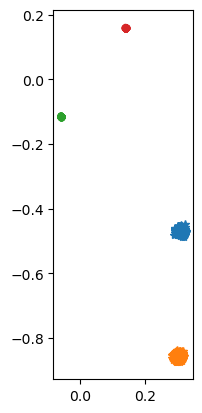

In [34]:
# these files are from the crate :
logfile_crate = '/data/smurf_data/20250624/1750806949/outputs/1750806949.log'
directory_path_crate = '/data/smurf_data/20250624/1750806949/outputs/'
crate_tune_file = '/data/smurf_data/tune/1750808478_tune.npy'
crate_file_list =  ['1750808504_single_channel_b2ch066', '1750808528_single_channel_b2ch290']

# these files are from the rfsoc: 
logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1750959423_tune.npy'
rfsoc_file_list =  ['1750959449_single_channel_b2ch066', '1750959472_single_channel_b2ch290']

# now load them all, and make them 

# plot tune file 
for file in crate_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_crate+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='*', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(power_db)


for file in rfsoc_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='.', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(power_db)

plt.gca().set_aspect('equal')



In [ ]:
[-5.09572915 -4.92862576 -5.22151851 ... -4.9676485  -4.89849353
 -4.97323543]
[-0.84672915 -0.97062957 -0.84668999 ... -0.77279863 -0.79687468
 -0.82808506]
[-18.20224272 -18.19285092 -18.1306489  ... -18.19941536 -18.01988211
 -18.05841452]
[-14.0332415  -14.01767541 -14.07428423 ... -13.87734094 -13.91825089
 -13.99491862]

/data/smurf_data/20250626/1750957495/outputs/1750957495.log


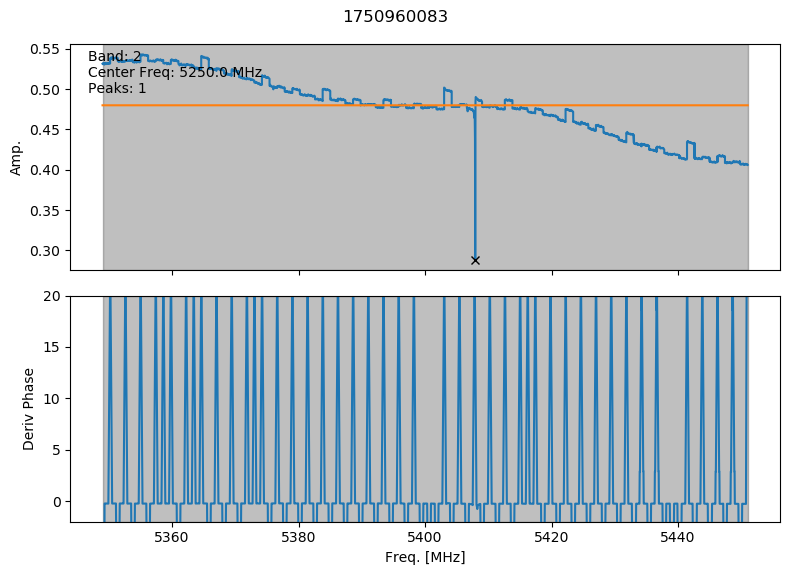

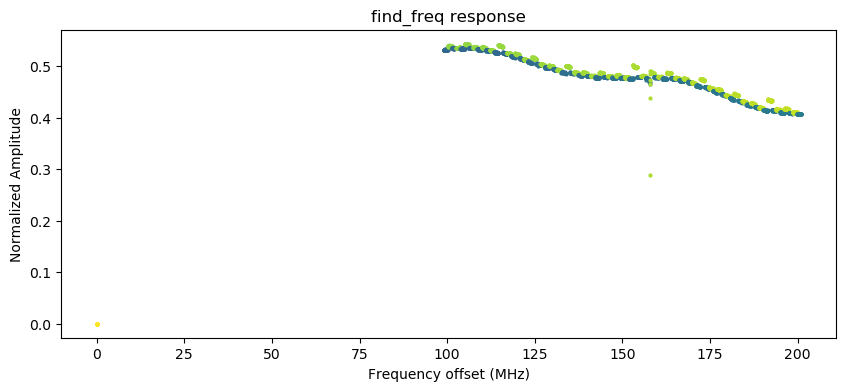

/data/smurf_data/tune/1750960094_tune.npy
Fr from fit  [GHz]: 5407.920371254348
Fr min curve [GHz]: 5407.917
Fit dictionary parameters:   {'f0': 5407.920371254348, 'Qr': 160585.1025094004, 'phi': -0.3247843665668743, 'zOff': (-0.5863989830141665-0.006453453520243054j), 'QcHat': 374857.74532335525, 'tau': (-0.000998168121244352+0.0008231429308628982j), 'Qc': 395536.5721286802}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


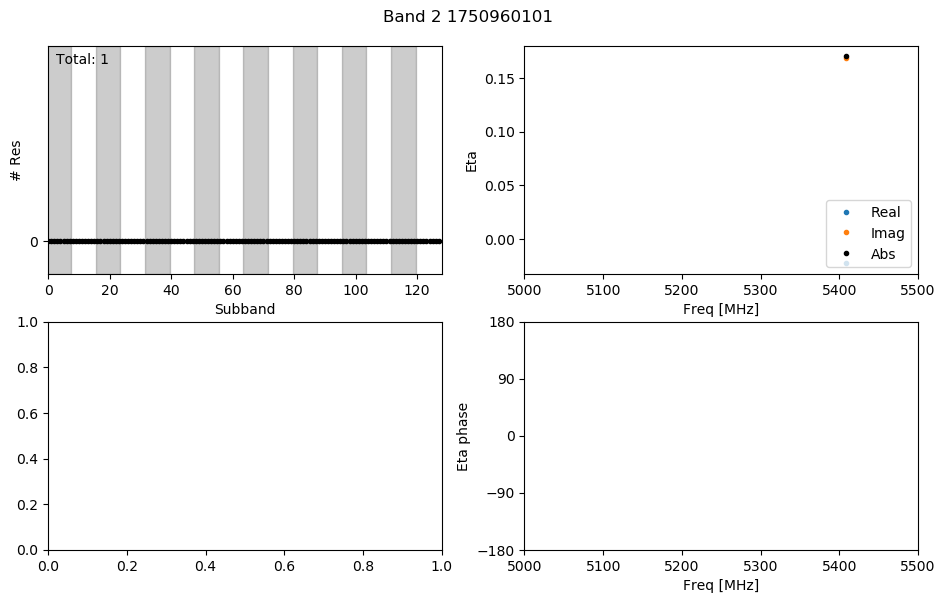

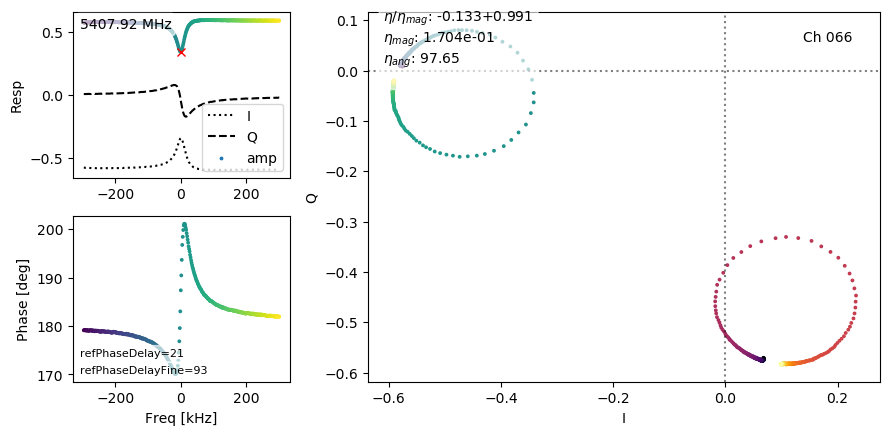

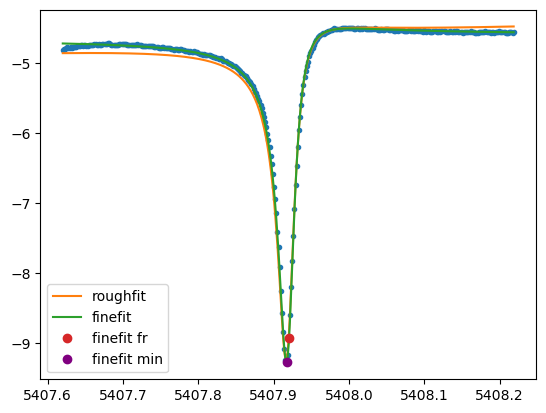

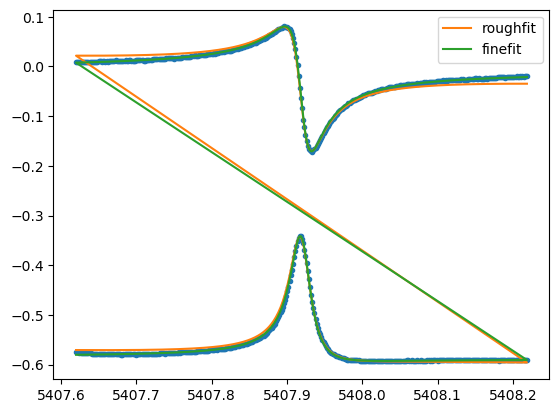

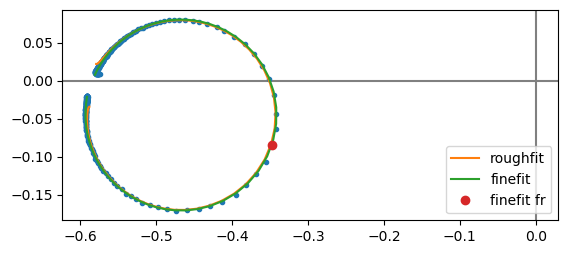

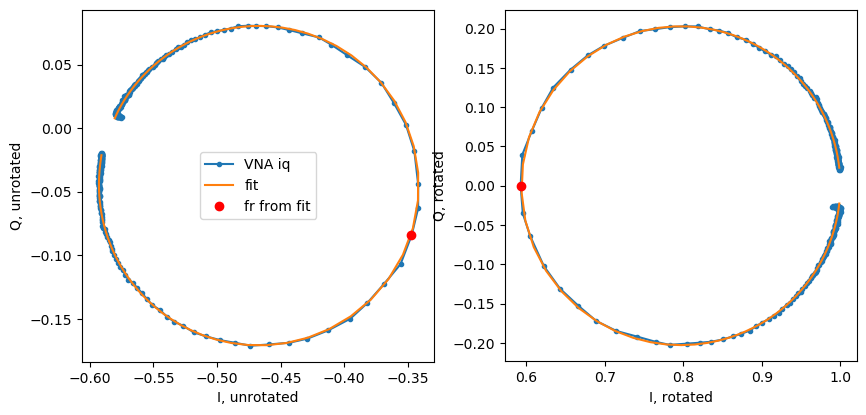

TIME: 1750960106
running char tones
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!


In [35]:

print( S.log.logfile.name)
TONE_POWER = 15

CH_GUESS = 66

NSAMP = 2**25

CHAN_MODE  = 2

NSAMP_CHAR = 2**15

CHAR_OFFSETS = [-0.2, -.1, 0, .1, 0.2]


ITERATIONS = 1

COOLDOWN = 'Olaf18'

DECIMATION = 0
FILTER_CUTOFF=2.4e6

F_OFF_RES = 5415 


LED_settings = {}


RF_settings = {'chain': ['Smurf out',\
               'LNF-LNR1_15B_SV',\
               '20 dB',\
               'C0', COOLDOWN, 'A2',\
               'ZX60-05113LN+',\
               '10 dB',\
               'ZX60-83LN-S+',\
               'Smurf in']}


AWG_settings = {}



## decide on decimation and filtering

S.find_freq(2,tone_power=13,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)
print(S.tune_file)

tune_dict=load_tune_file(S.tune_file, BAND)


S.set_feedback_enable_channel(BAND,CH_GUESS,0)
    
for ch in S.which_on(BAND):
    S.channel_off(BAND, ch)
    
    
fit_dict, fine_errs = fit_data(S.tune_file, BAND, plot=True)
char_offset_scale = fit_dict['f0'] / fit_dict['Qr'] 

plt.show()



#S.set_decimation(BAND, DECIMATION)
#S.set_debug_data_filter_cutoff(BAND, FILTER_CUTOFF)


file_list = []
MEMS_settings = {'mirror_position':[0,0], 'mirror_params':(90, 169, 120)}
    
for ii in range(ITERATIONS):
    print('TIME:', S.get_timestamp())    
    char_avgs = {}
    print('running char tones')
    for f_offs in CHAR_OFFSETS:
        new_freq = fit_dict['f0'] + char_offset_scale * f_offs 
        S.set_fixed_tone(new_freq, TONE_POWER)
        timestamp = S.get_timestamp() 
        channel = S.which_on(BAND)[0]
        filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
        i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP_CHAR,filename=filename, single_channel_readout=CHAN_MODE)
        avg = np.mean(i+1j*q)
        char_avgs[new_freq] = [avg.real, avg.imag]
        for ch in S.which_on(BAND):
            S.channel_off(BAND, ch)


   


    print('taking real data')
    S.set_fixed_tone(fit_dict['f0'], TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    

    print('taking real data')
    S.set_fixed_tone(F_OFF_RES, TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    


In [36]:
print(f"logfile = '{S.log.logfile.name}'")
print(f"directory_path_rfsoc = '{'/'.join(S.log.logfile.name.split('/')[0:-1])}/'")
print(f"rfsoc_tune_file = '{S.tune_file}'")
print('rfsoc_file_list = ',file_list)

logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1750960094_tune.npy'
rfsoc_file_list =  ['1750960119_single_channel_b2ch066', '1750960142_single_channel_b2ch290']


[-5.09572915 -4.92862576 -5.22151851 ... -4.9676485  -4.89849353
 -4.97323543]
[-0.84672915 -0.97062957 -0.84668999 ... -0.77279863 -0.79687468
 -0.82808506]
[-8.66901156 -8.63257055 -8.66757729 ... -8.59333213 -8.56502424
 -8.6175964 ]
[-4.64465179 -4.60010735 -4.62931946 ... -4.61640619 -4.60945695
 -4.60927161]


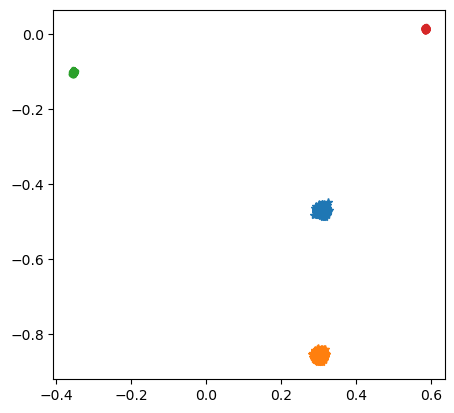

In [37]:
# these files are from the crate :
logfile_crate = '/data/smurf_data/20250624/1750806949/outputs/1750806949.log'
directory_path_crate = '/data/smurf_data/20250624/1750806949/outputs/'
crate_tune_file = '/data/smurf_data/tune/1750808478_tune.npy'
crate_file_list =  ['1750808504_single_channel_b2ch066', '1750808528_single_channel_b2ch290']

# these files are from the rfsoc: 
logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1750960094_tune.npy'
rfsoc_file_list =  ['1750960119_single_channel_b2ch066', '1750960142_single_channel_b2ch290']

# now load them all, and make them 

# plot tune file 
for file in crate_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_crate+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='*', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(power_db)


for file in rfsoc_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='.', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(power_db)

plt.gca().set_aspect('equal')



Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function set_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function set_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping ca

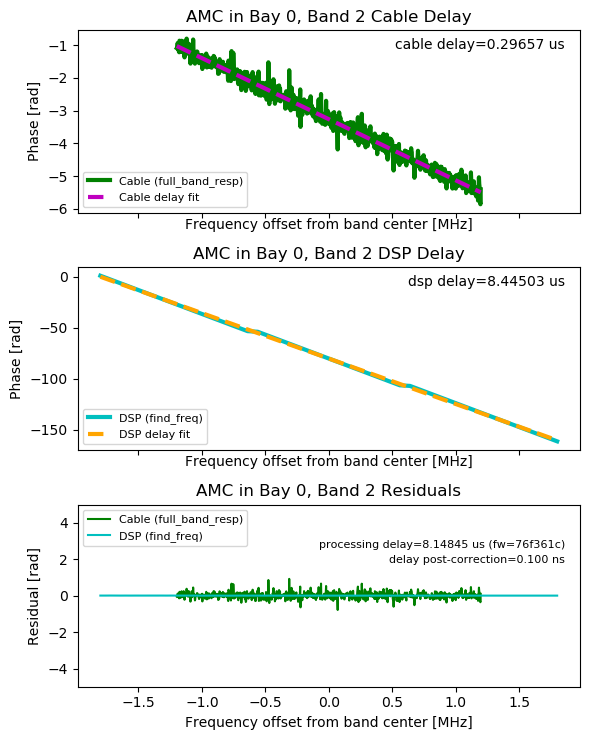

(8.445025052165473, 9.957845876824586e-05)

In [42]:
S.estimate_phase_delay(2,freq_min=-1200000,freq_max=1200000)

/data/smurf_data/20250626/1750957495/outputs/1750957495.log


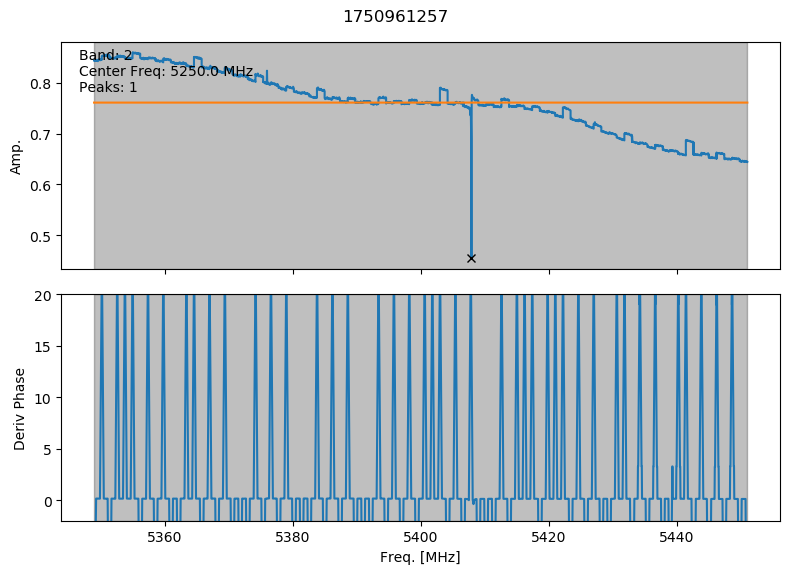

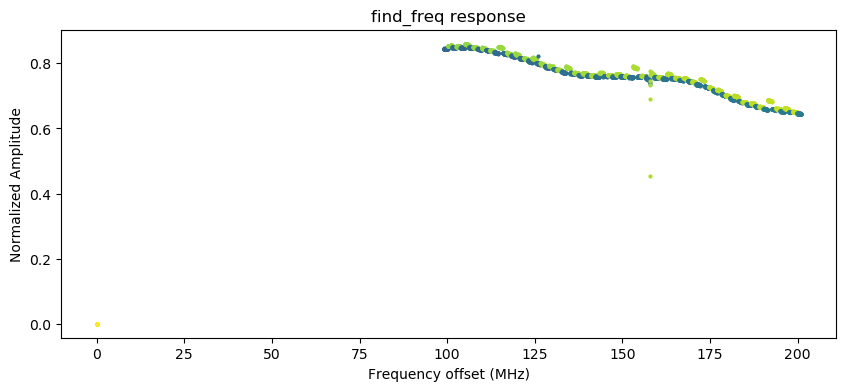

/data/smurf_data/tune/1750961269_tune.npy
Fr from fit  [GHz]: 5407.920383779032
Fr min curve [GHz]: 5407.917
Fit dictionary parameters:   {'f0': 5407.920383779032, 'Qr': 160559.00023884105, 'phi': -0.32300768516118206, 'zOff': (0.9229450121278249+0.0659390611705407j), 'QcHat': 374624.8671216319, 'tau': (0.002425917572560096+0.0007632904674738187j), 'Qc': 395055.14019543794}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


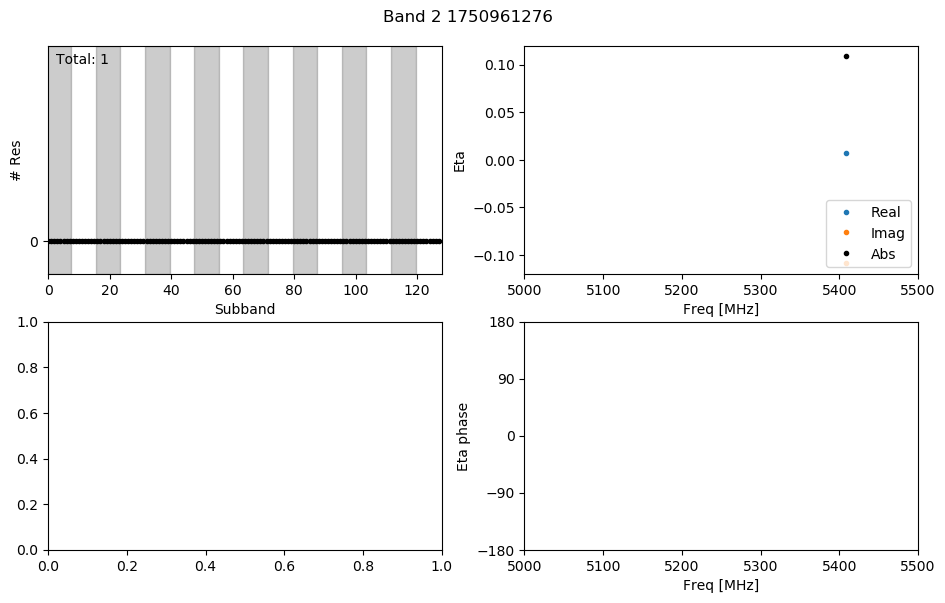

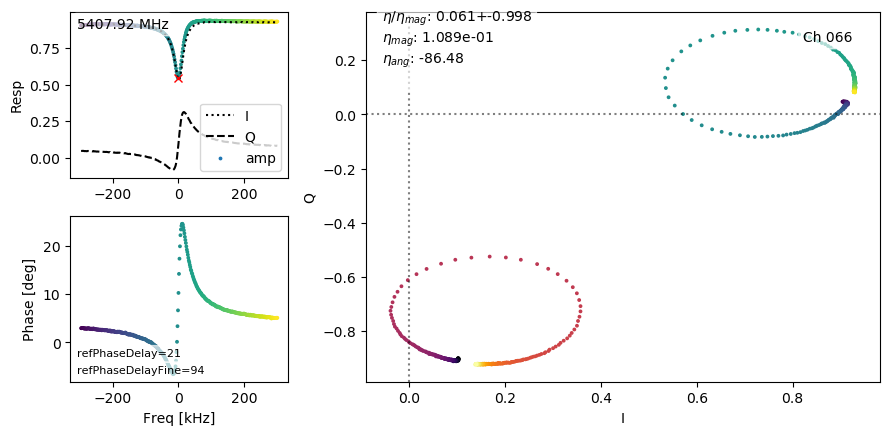

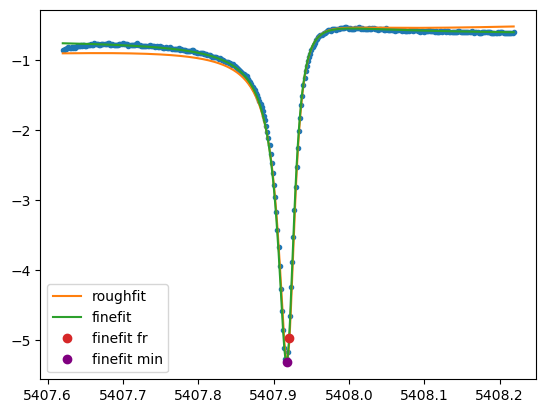

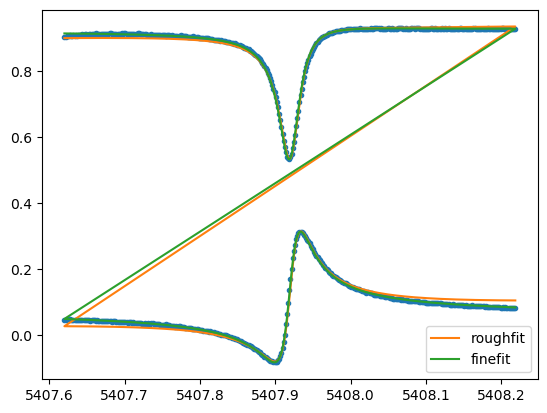

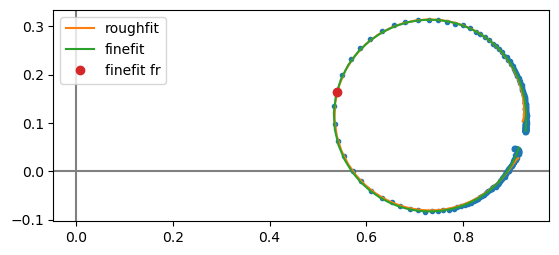

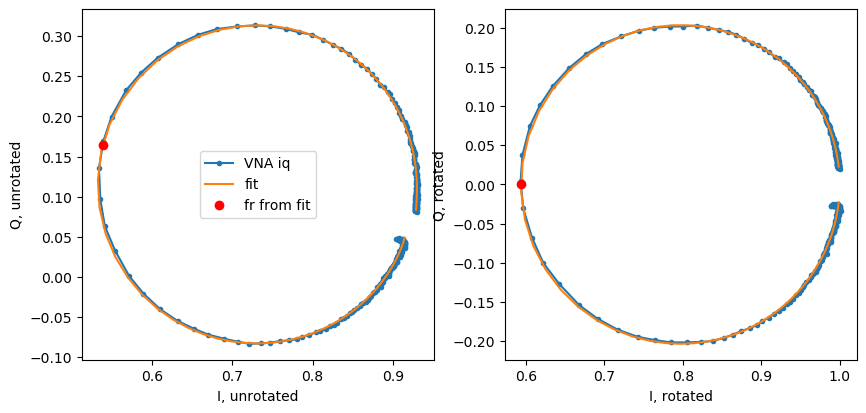

TIME: 1750961281
running char tones
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!


In [46]:

print( S.log.logfile.name)
TONE_POWER = 15

CH_GUESS = 66

NSAMP = 2**25

CHAN_MODE  = 2

NSAMP_CHAR = 2**15

CHAR_OFFSETS = [-0.2, -.1, 0, .1, 0.2]


ITERATIONS = 1

COOLDOWN = 'Olaf18'

DECIMATION = 0
FILTER_CUTOFF=2.4e6

F_OFF_RES = 5415 


LED_settings = {}


RF_settings = {'chain': ['Smurf out',\
               'LNF-LNR1_15B_SV',\
               '20 dB',\
               'C0', COOLDOWN, 'A2',\
               'ZX60-05113LN+',\
               '6 dB',\
               'ZX60-83LN-S+',\
               'Smurf in']}


AWG_settings = {}



## decide on decimation and filtering

S.find_freq(2,tone_power=13,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)
print(S.tune_file)

tune_dict=load_tune_file(S.tune_file, BAND)


S.set_feedback_enable_channel(BAND,CH_GUESS,0)
    
for ch in S.which_on(BAND):
    S.channel_off(BAND, ch)
    
    
fit_dict, fine_errs = fit_data(S.tune_file, BAND, plot=True)
char_offset_scale = fit_dict['f0'] / fit_dict['Qr'] 

plt.show()



#S.set_decimation(BAND, DECIMATION)
#S.set_debug_data_filter_cutoff(BAND, FILTER_CUTOFF)


file_list = []
MEMS_settings = {'mirror_position':[0,0], 'mirror_params':(90, 169, 120)}
    
for ii in range(ITERATIONS):
    print('TIME:', S.get_timestamp())    
    char_avgs = {}
    print('running char tones')
    for f_offs in CHAR_OFFSETS:
        new_freq = fit_dict['f0'] + char_offset_scale * f_offs 
        S.set_fixed_tone(new_freq, TONE_POWER)
        timestamp = S.get_timestamp() 
        channel = S.which_on(BAND)[0]
        filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
        i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP_CHAR,filename=filename, single_channel_readout=CHAN_MODE)
        avg = np.mean(i+1j*q)
        char_avgs[new_freq] = [avg.real, avg.imag]
        for ch in S.which_on(BAND):
            S.channel_off(BAND, ch)


   


    print('taking real data')
    S.set_fixed_tone(fit_dict['f0'], TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    

    print('taking real data')
    S.set_fixed_tone(F_OFF_RES, TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    


In [47]:
print(f"logfile = '{S.log.logfile.name}'")
print(f"directory_path_rfsoc = '{'/'.join(S.log.logfile.name.split('/')[0:-1])}/'")
print(f"rfsoc_tune_file = '{S.tune_file}'")
print('rfsoc_file_list = ',file_list)

logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1750961269_tune.npy'
rfsoc_file_list =  ['1750961294_single_channel_b2ch066', '1750961318_single_channel_b2ch290']


-5.0067847657538715
-0.8306020986471436
-4.7204241358363355
-0.6536169077582614


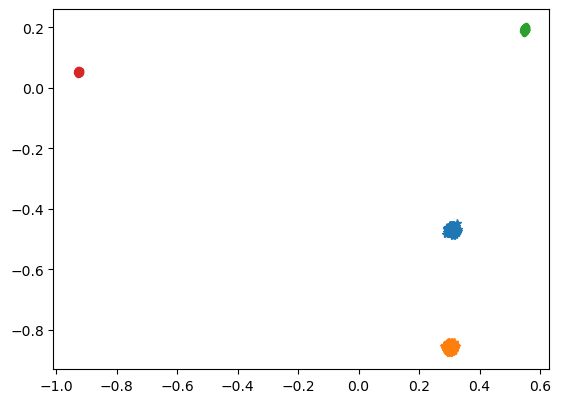

In [49]:
# these files are from the crate :
logfile_crate = '/data/smurf_data/20250624/1750806949/outputs/1750806949.log'
directory_path_crate = '/data/smurf_data/20250624/1750806949/outputs/'
crate_tune_file = '/data/smurf_data/tune/1750808478_tune.npy'
crate_file_list =  ['1750808504_single_channel_b2ch066', '1750808528_single_channel_b2ch290']

# these files are from the rfsoc: 
logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1750961269_tune.npy'
rfsoc_file_list =  ['1750961294_single_channel_b2ch066', '1750961318_single_channel_b2ch290']

# now load them all, and make them 

# plot tune file 
for file in crate_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_crate+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='*', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(np.mean(power_db))


for file in rfsoc_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='.', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(np.mean(power_db))

plt.gca().set_aspect('equal')



Ok now that we have relativley similar powers, let's try and pipe in smurf crate tones to stabilize find freqs 

In [54]:
# OK! piped in the RF out from Smurf crate, turned tone on 5150 and 5250 
# which we can see in the Read ADC data

In [50]:
S.which_on(2)

array([], dtype=int64)

array([  17.+131.j,  -29. -47.j, -275.-105.j, ..., -173.+318.j,
        -38.+169.j, -107. -94.j])

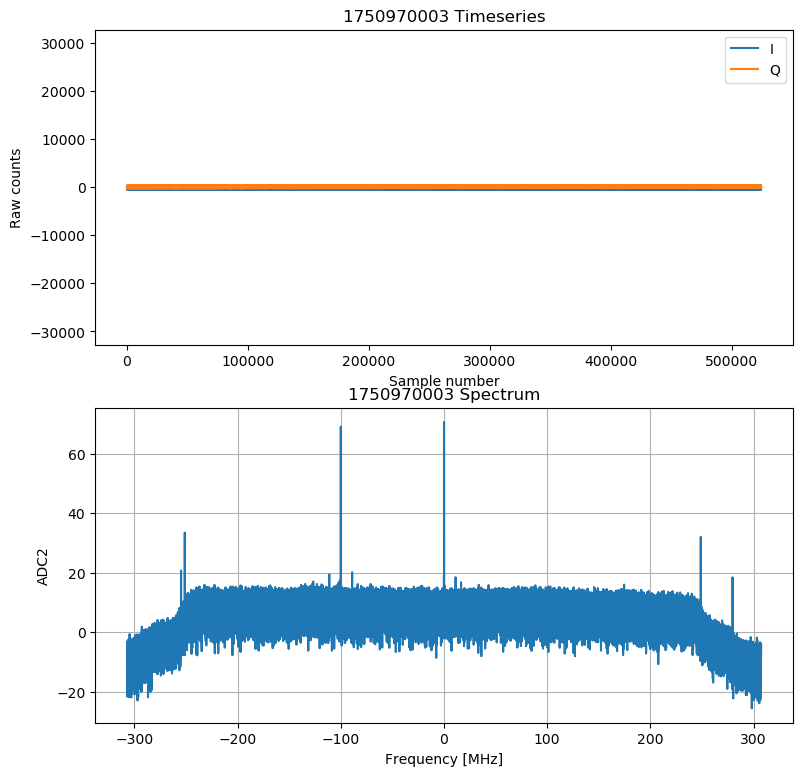

In [57]:
S.read_adc_data(2, make_plot=True, show_plot=True)

Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function set_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function set_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_uc called, but not implemented on RFSoC.  Skipping ca

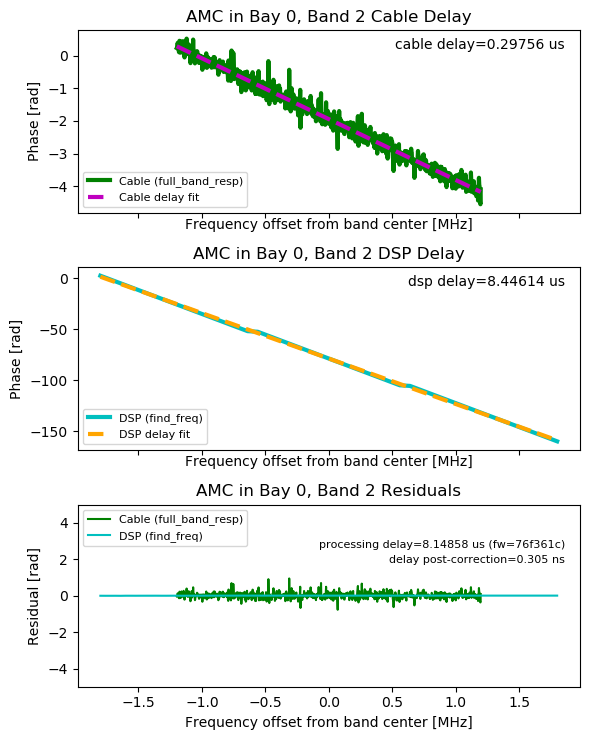

(8.446140824400281, 0.0003053829618578115)

In [55]:
S.estimate_phase_delay(2,freq_min=-1200000,freq_max=1200000)

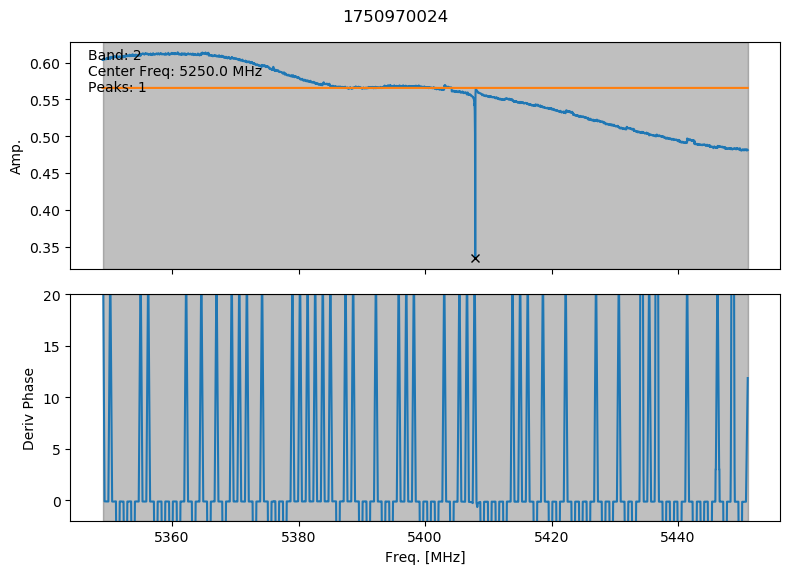

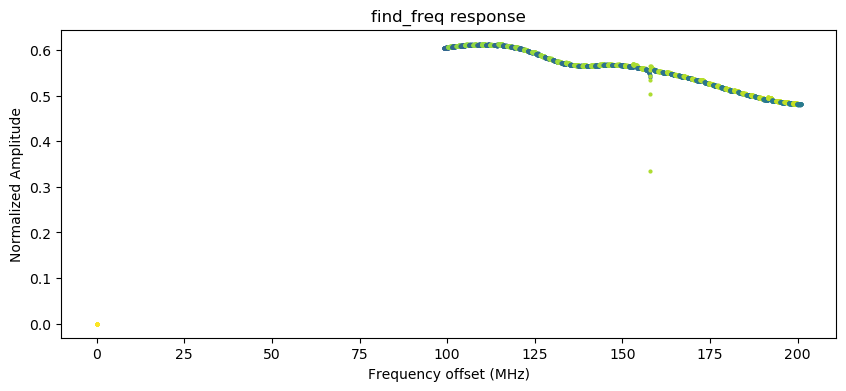

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [58]:

S.find_freq(2,tone_power=14,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 



array([ 201.+275.j,  147. +41.j, -282. +86.j, ..., -963.+252.j,
       -293.+852.j,  277.+367.j])

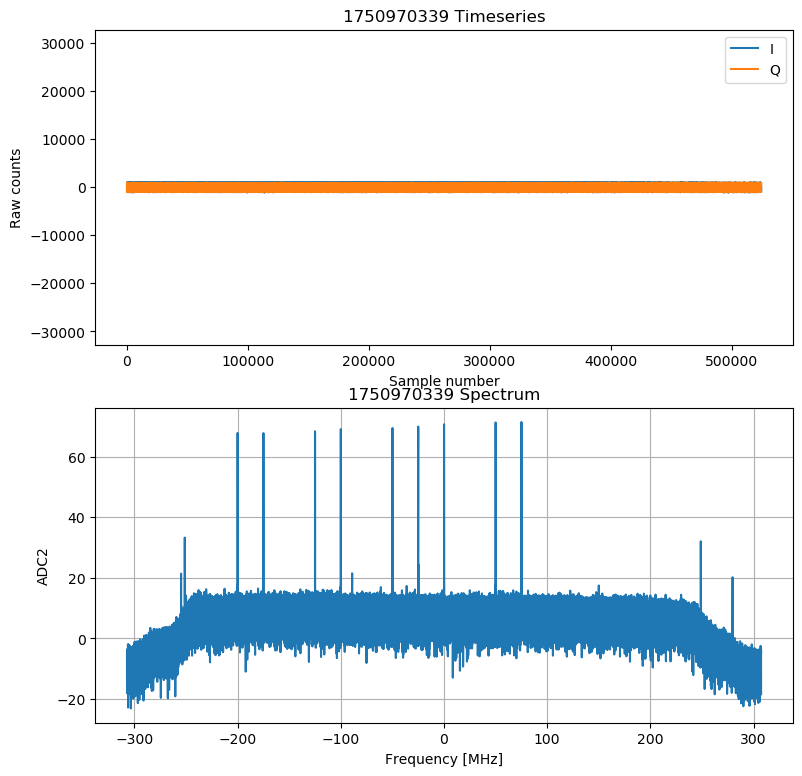

In [65]:
S.read_adc_data(2, make_plot=True, show_plot=True)

16384

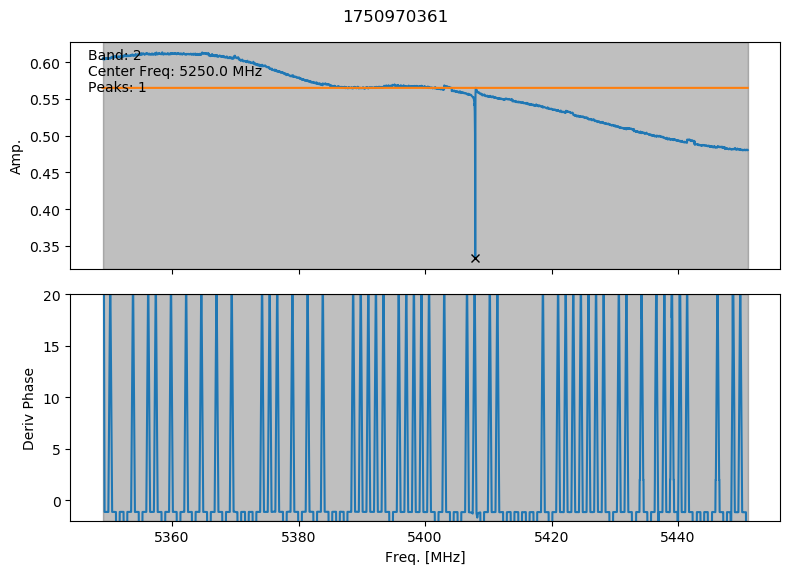

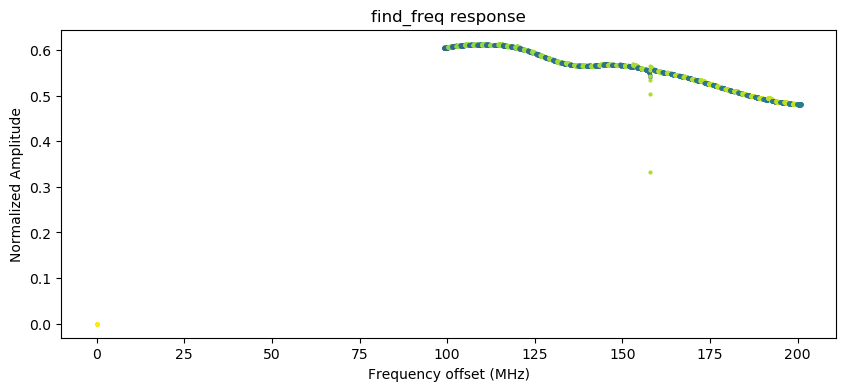

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [66]:

S.find_freq(2,tone_power=14,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


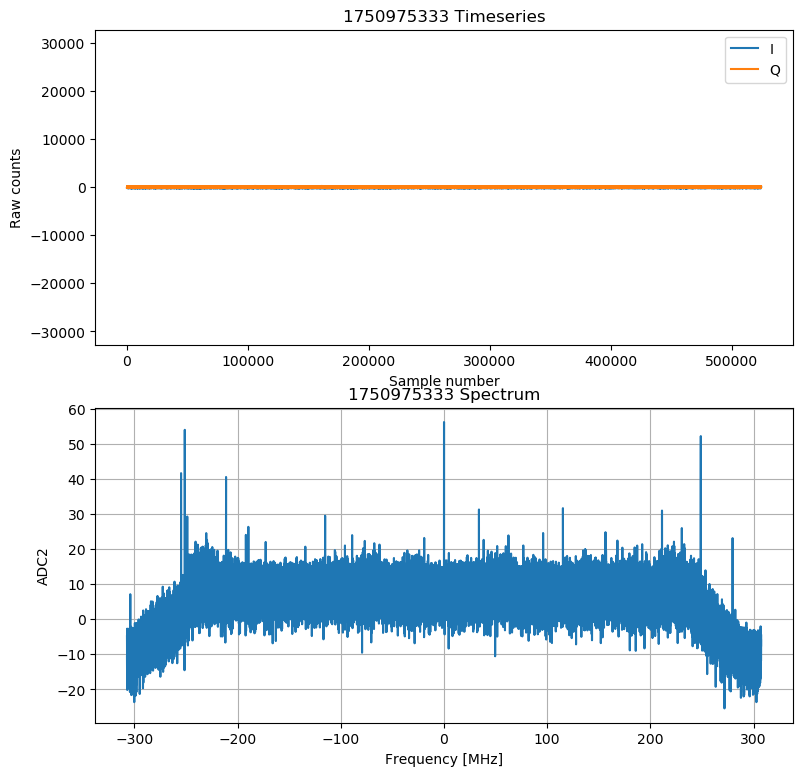

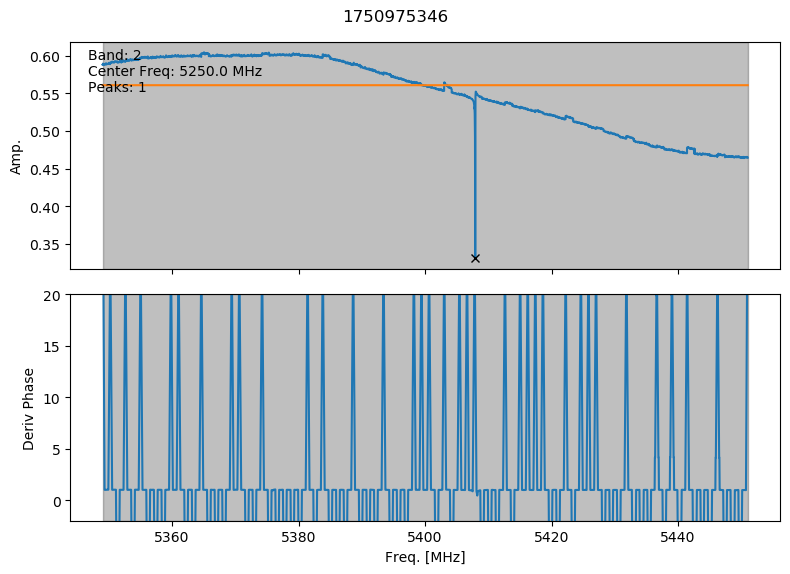

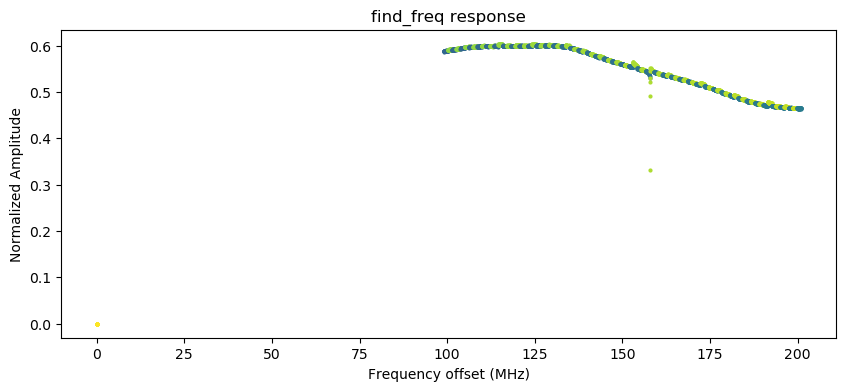

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [94]:
S.read_adc_data(2, make_plot=True, show_plot=True)

S.find_freq(2,tone_power=14,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


In [69]:
tone_power = 14
tp_dbm = -30 - (12-tone_power)*3
gain = np.array([36, -20, -50, +40, +22, -6 ])
gain2device = gain[0:3]
print(f'roundtrip gain: {np.sum(gain)}')
print(f'power at device: {tone_power + np.sum(gain2device)}')
print(f'tone power into smurf: {tone_power + np.sum(gain)}')

# now hemt is on  

roundtrip gain: 22
power at device: -20
tone power into smurf: 36


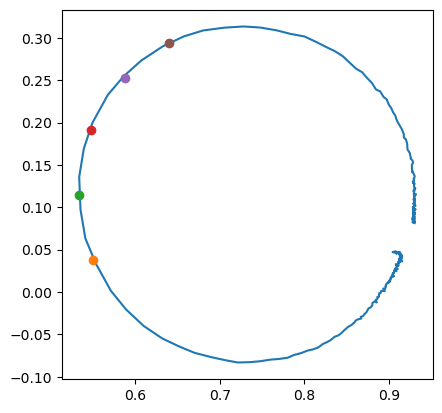

In [76]:
rfsoc_tune_file = '/data/smurf_data/tune/1750961269_tune.npy'

tune_dict = load_tune_file(rfsoc_tune_file, 2, db_offset=1)
vna = tune_dict['r']
    
plt.plot(vna.real, vna.imag)


for freq in char_avgs.keys():
    plt.plot(char_avgs[freq][0]/1.2, char_avgs[freq][1]/(-1.2), marker='o')

plt.gca().set_aspect('equal')

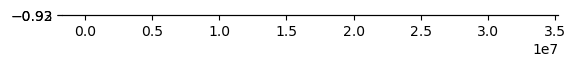

In [82]:
## PSUDO CODE: SMURF
# 1. run your characterization tones
# 2. Send "turn on" message to splendaq 
# 3. wait for "LED is ON" message from splendaq
# 4. run the real data code 
# 5. send "Turn off" message to splendaq

def check4MessageFromSplendaq(file_name):
    with open(file_name, 'r') as file_r:
        contents = file_r.read()
        if contents.split(':')[0] == "SMuRF":
            #print("no updates")
            msg = ["SMuRF", None]
        elif contents.split(':')[0] == "Splendaq":
            msg = contents.split(':')
        else: msg = "ERROR??"
    return msg

def writeMessage2Splendaq(file_name, msg):
    with open(file_name, 'w') as file_w:
        file_w.write(f"SMuRF:{msg}")
    return

import re
import ast

def returnUsefulLog(log_msg):
    joined_Log = ':'.join(log_msg)
    dict_match = re.search(r"\[.*?\]", joined_Log )
    # Extract the temp value
    temp_match = re.search(r"temp=([\d.eE+-]+)", joined_Log )

    if dict_match and temp_match:
        dict_list = ast.literal_eval(dict_match.group(0))
        temp_value = float(temp_match.group(1))
        dict_list.append(temp_value)
    return dict_list



# Acceptable messges: 
# SMuRF:turn LED ON:A1:A2
# SMuRF:turn LED OFF
# SMuRF:Operation complete
# Splendaq:LED is ON
# Splendaq:LED is OFF


/data/smurf_data/20250626/1750957495/outputs/1750957495.log


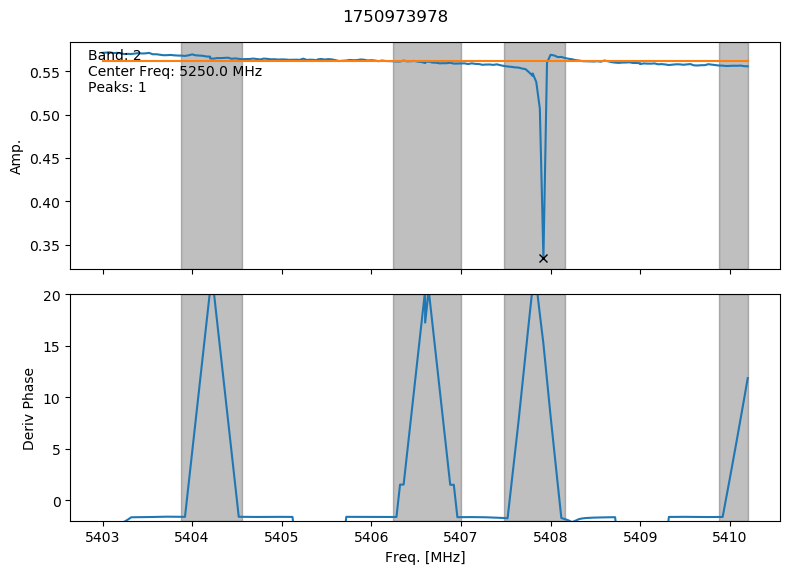

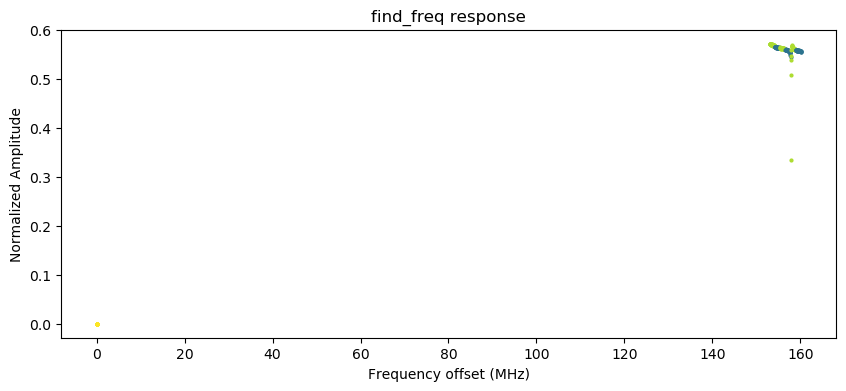

/data/smurf_data/tune/1750973989_tune.npy
Fr from fit  [GHz]: 5407.920313952173
Fr min curve [GHz]: 5407.917
Fit dictionary parameters:   {'f0': 5407.920313952173, 'Qr': 160588.80438639593, 'phi': -0.32422695476037217, 'zOff': (-0.576082626131083+0.1056572835054065j), 'QcHat': 374021.85576264135, 'tau': (0.0008749371129370879-0.0003455842687577322j), 'Qc': 394580.57568544545}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


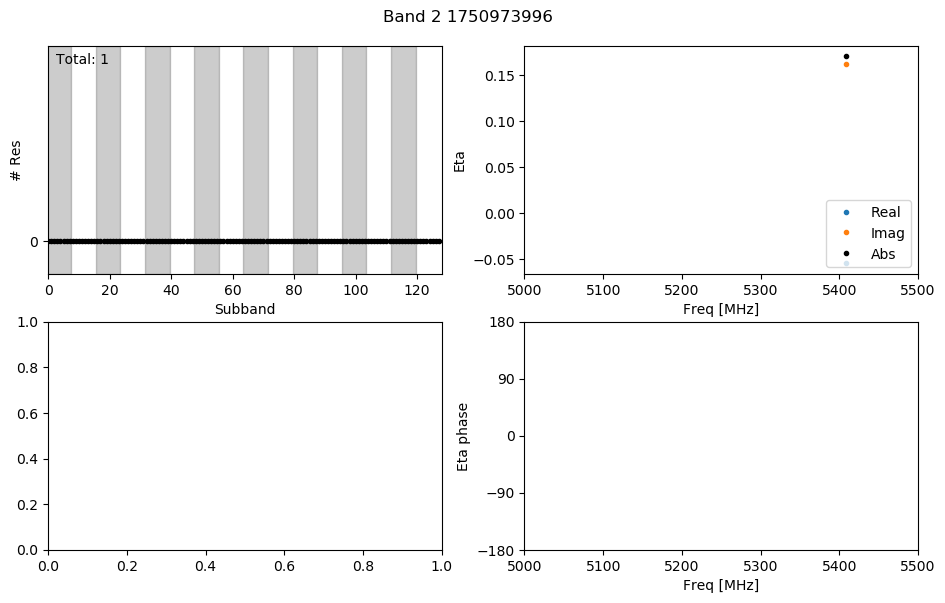

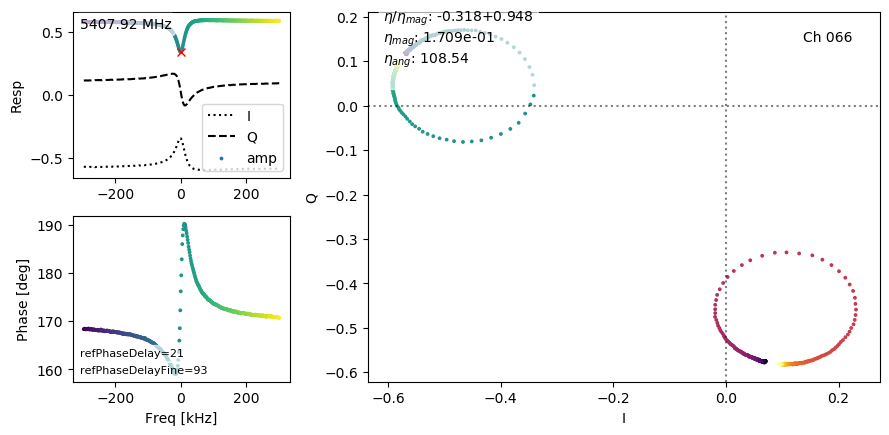

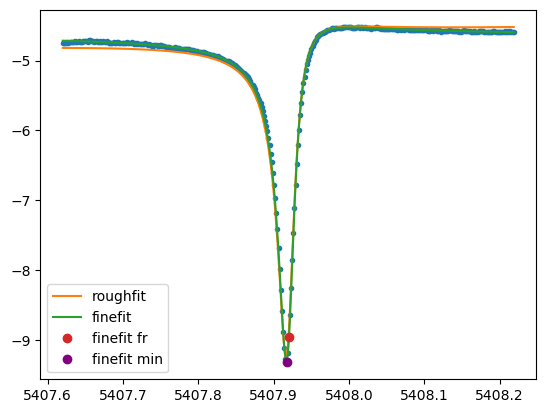

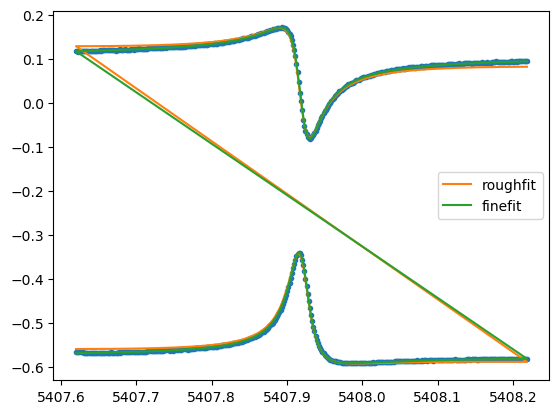

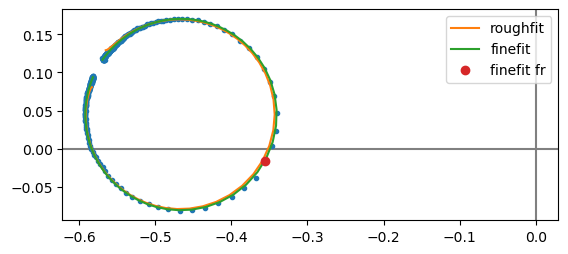

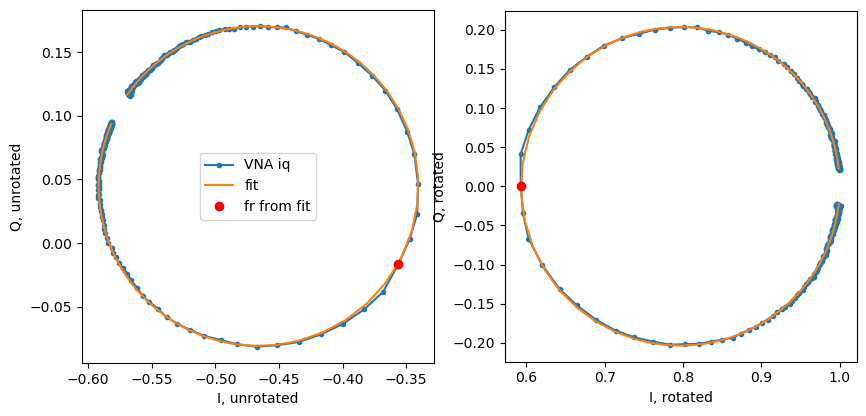

TIME: 1750974000
running char tones
asking to turn LED on
waiting for response...
['SMuRF', None]
['SMuRF', None]
['Splendaq', 'LED is ON']
confirmed, LED is ON
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
asking to turn LED off
waiting for confirmation
confirmed, LED is OFF
TIME: 1750974047
running char tones
asking to turn LED on
waiting for response...
['SMuRF', None]
['Splendaq', 'LED is ON']
confirmed, LED is ON
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
asking to turn LED off
waiting for confirmation
confirmed, LED is OFF
TIME: 1750974093
running char tones
asking to turn LED on
waiting for response...
['SMuRF', None]
['Splendaq', 'LED is ON']
confirmed, LED is ON
tak

In [86]:

print( S.log.logfile.name)
TONE_POWER = 15

CH_GUESS = 66

NSAMP = 2**25

CHAN_MODE  = 2

NSAMP_CHAR = 2**15

CHAR_OFFSETS = [-0.2, -.1, 0, .1, 0.2]


ITERATIONS = 5

COOLDOWN = 'Olaf18'

DECIMATION = 0
FILTER_CUTOFF=2.4e6




LED_settings = {}
LED_settings['P/N'] = 'M625F2'
LED_settings['wavelength (nm)'] = 625
LED_settings['current limit (mA)'] = 500
LED_settings['Vmax (V)'] = 5
LED_settings['mod coeff  (mA/V)'] = 400
LED_settings['input impedance (kOhm)'] = 10


RF_settings = {'chain': ['Smurf out',\
               'LNF-LNR1_15B_SV',\
               '20 dB',\
               'C0', COOLDOWN, 'A2',\
               'ZX60-05113LN+',\
               '6 dB',\
               'ZX60-83LN-S+',\
                'ZFSC-2-10G+',\
               'Smurf in']}


AWG_settings = {}



## decide on decimation and filtering

S.find_freq(2,tone_power=14,\
                start_freq=154,stop_freq=160,make_plot=True,show_plot=True,\
                amp_cut=0.05,rolling_med=False) #amp cut decides what you count for a resonator 


S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)
print(S.tune_file)

tune_dict=load_tune_file(S.tune_file, BAND)


S.set_feedback_enable_channel(BAND,CH_GUESS,0)
    
for ch in S.which_on(BAND):
    S.channel_off(BAND, ch)
    
    
fit_dict, fine_errs = fit_data(S.tune_file, BAND, plot=True)
char_offset_scale = fit_dict['f0'] / fit_dict['Qr'] 

plt.show()





coms_file_name = r"/usr/local/src/pysmurf/scratch/talk2splendaq/coms.txt"
add2log_file_name = r"/usr/local/src/pysmurf/scratch/talk2splendaq/add2log.txt"

OFF = True
super_break = False




#S.set_decimation(BAND, DECIMATION)
#S.set_debug_data_filter_cutoff(BAND, FILTER_CUTOFF)


file_list = []

A1 = 2.7
A2 = 2.7


MEMS_settings = {'mirror_position':[0,0], 'mirror_params':(90, 169, 120)}
    
for ii in range(ITERATIONS):
    print('TIME:', S.get_timestamp())    
    char_avgs = {}
    print('running char tones')
    for f_offs in CHAR_OFFSETS:
        new_freq = fit_dict['f0'] + char_offset_scale * f_offs 
        S.set_fixed_tone(new_freq, TONE_POWER)
        timestamp = S.get_timestamp() 
        channel = S.which_on(BAND)[0]
        filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
        i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP_CHAR,filename=filename, single_channel_readout=CHAN_MODE)
        avg = np.mean(i+1j*q)
        char_avgs[new_freq] = [avg.real, avg.imag]
        for ch in S.which_on(BAND):
            S.channel_off(BAND, ch)


    print('asking to turn LED on')
    #writeMessage2Splendaq(coms_file_name, f'turn LED ON:{A1}:{A2}:{T1}:{T2}')
    writeMessage2Splendaq(coms_file_name, f'turn LED ON:{A1}:{A2}')
    print('waiting for response...')
    while OFF == True and super_break == False:
        msg = check4MessageFromSplendaq(coms_file_name)
        print(msg)
        if msg[1] == "LED is ON":
            print("confirmed, LED is ON")
            log_msg = check4MessageFromSplendaq(add2log_file_name)
            log_list = returnUsefulLog(log_msg)
            pulse_1_dict = log_list[0]
            #pulse_2_dict = log_list[1]
                
            # TODO get log msg into proper format
            AWG_settings["pulse_duration_us"] = [pulse_1_dict['pulse_width']*1e6]#,pulse_2_dict['pulse_width']*1e6] #[13,13]
            AWG_settings["amplitudes"] = [pulse_1_dict['amplitude']-pulse_1_dict['offset']]#,pulse_2_dict['amplitude']-pulse_2_dict['offset']] 
            AWG_settings["wvfm_samp_rate_hz"] = []#1.25e6
            AWG_settings["chunk_duration_s"] = 1/(pulse_1_dict['frequency'])#(min(pulse_1_dict['frequency'], pulse_2_dict['frequency'])) #.5
            AWG_settings['pulse1_dict'] = pulse_1_dict
            #AWG_settings['pulse2_dict'] = pulse_2_dict

            temp = log_list[1]#[2]
            writeMessage2Splendaq(add2log_file_name, '')
            OFF = False
        sleep(2)

    print('taking real data')
    S.set_fixed_tone(fit_dict['f0'], TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict, temp=temp)
    print('asking to turn LED off')
    writeMessage2Splendaq(coms_file_name, 'turn LED OFF')
    print('waiting for confirmation')
    while OFF == False and super_break ==False:
        msg = check4MessageFromSplendaq(coms_file_name)
        if msg[1] == "LED is OFF":
            print("confirmed, LED is OFF")
            OFF = True
        sleep(2)
    
print(file_list)

#writeMessage2Splendaq(coms_file_name, 'Operation complete')



In [84]:
from time import sleep

-8.71841454394063


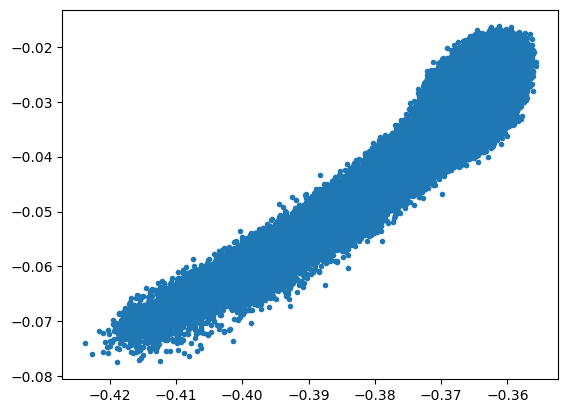

-8.740672219969678


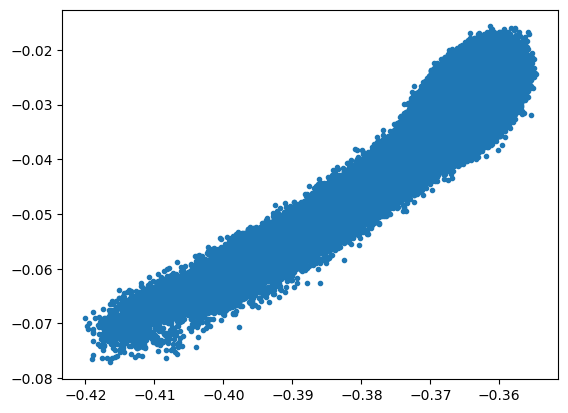

-8.722710822697813


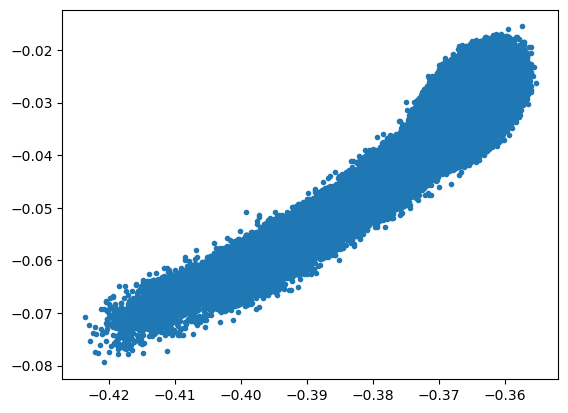

-8.720351336203205


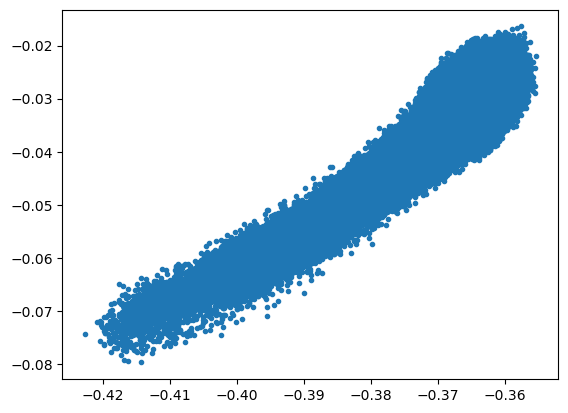

-8.719751971454505


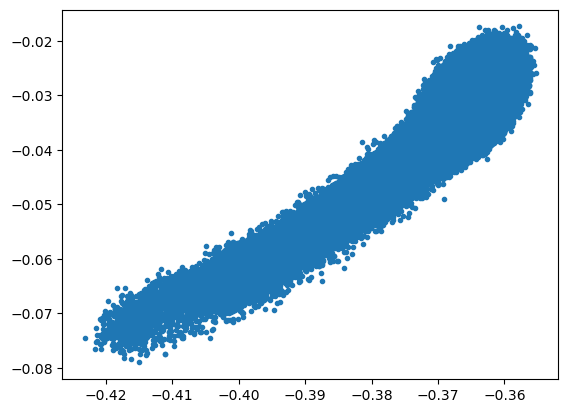

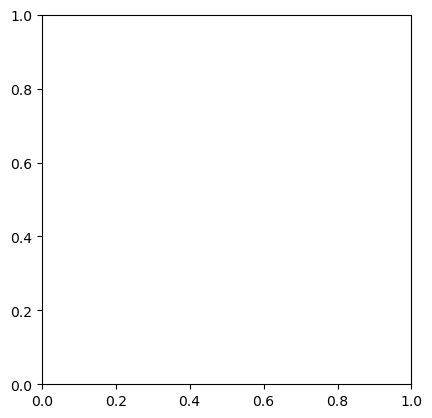

In [89]:
pulse_files = ['1750974020_single_channel_b2ch066', '1750974065_single_channel_b2ch066', '1750974109_single_channel_b2ch066', '1750974153_single_channel_b2ch066', '1750974198_single_channel_b2ch066']
for file in pulse_files: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i, q, marker='.', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(np.mean(power_db))
    plt.show()
plt.gca().set_aspect('equal')

array([ 33.  +3.j, -29. -12.j,  32.+106.j, ..., -69. -52.j, -99.+101.j,
       -43. -22.j])

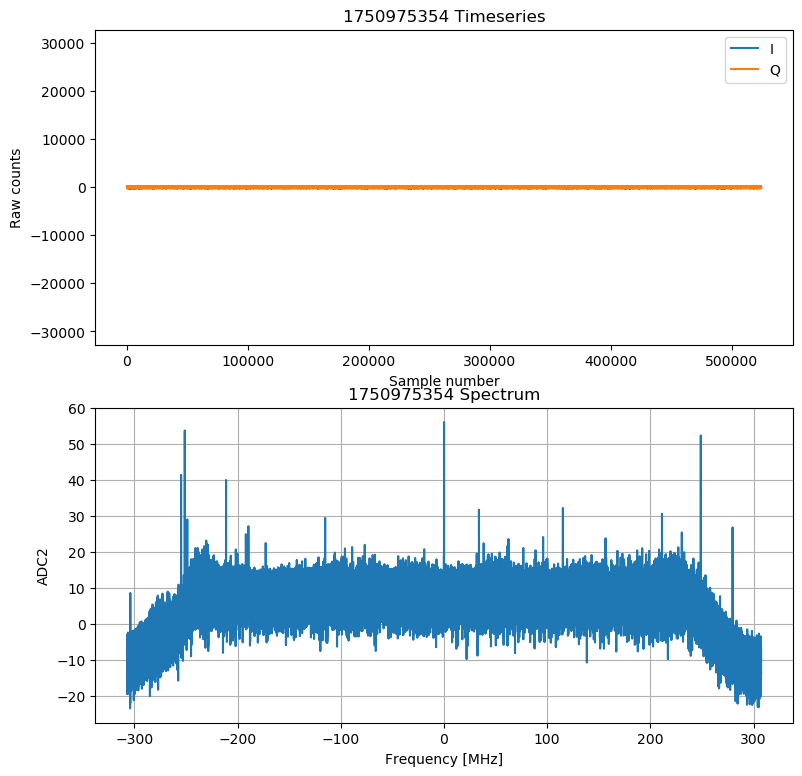

In [95]:
S.read_adc_data(2, make_plot=True, show_plot=True)

array([ 49.-31.j,  95. -8.j, 101.+45.j, ...,  40.-88.j, -44.-11.j,
       -99.+89.j])

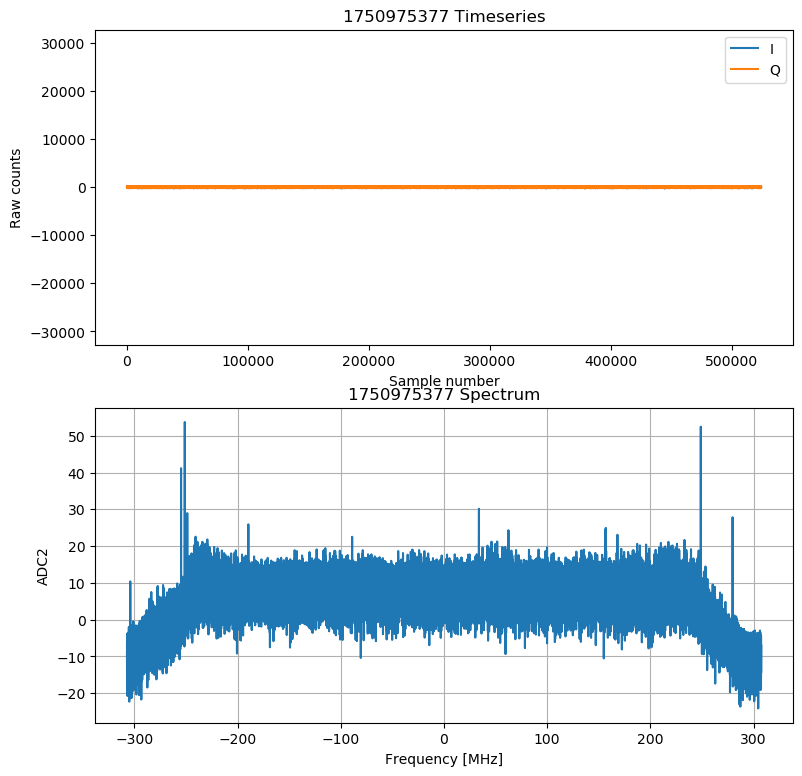

In [96]:
S.read_adc_data(2, make_plot=True, show_plot=True)

array([-493.+230.j, -303.+157.j, -322.+113.j, ..., -246.+248.j,
       -278.+129.j, -337.+196.j])

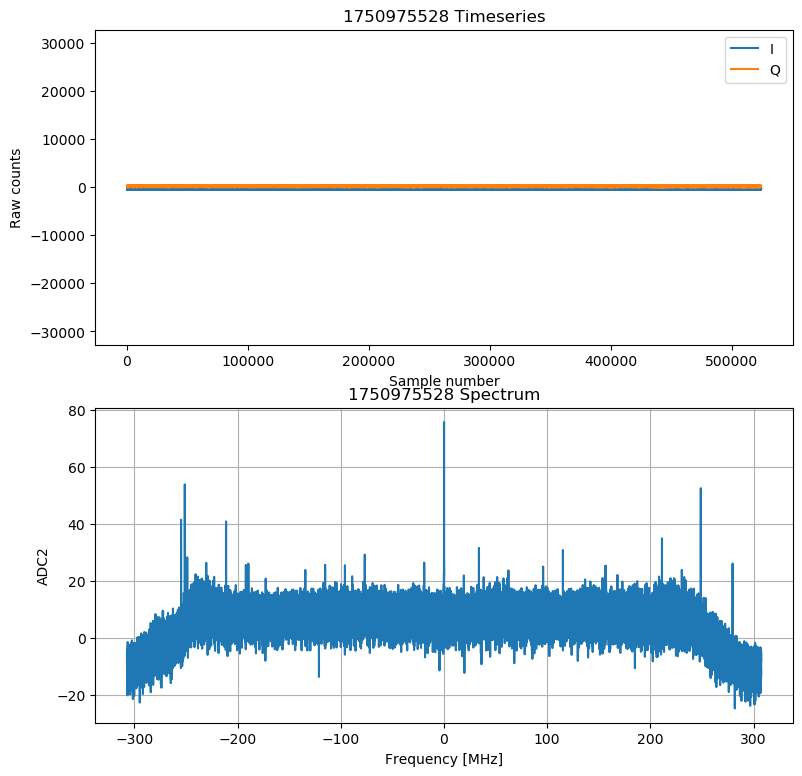

In [102]:
S.read_adc_data(2, make_plot=True, show_plot=True)

array([-2322. -284.j, -2274. +361.j, -1787. +595.j, ..., -2625. -287.j,
       -3133. +270.j, -3064.+1201.j])

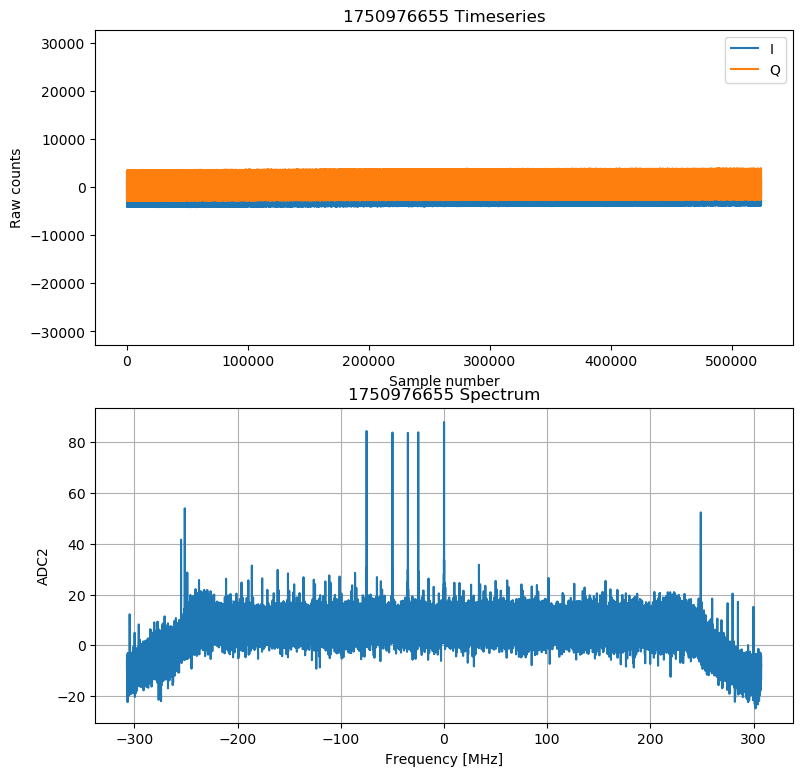

In [119]:
S.read_adc_data(2, make_plot=True, show_plot=True)

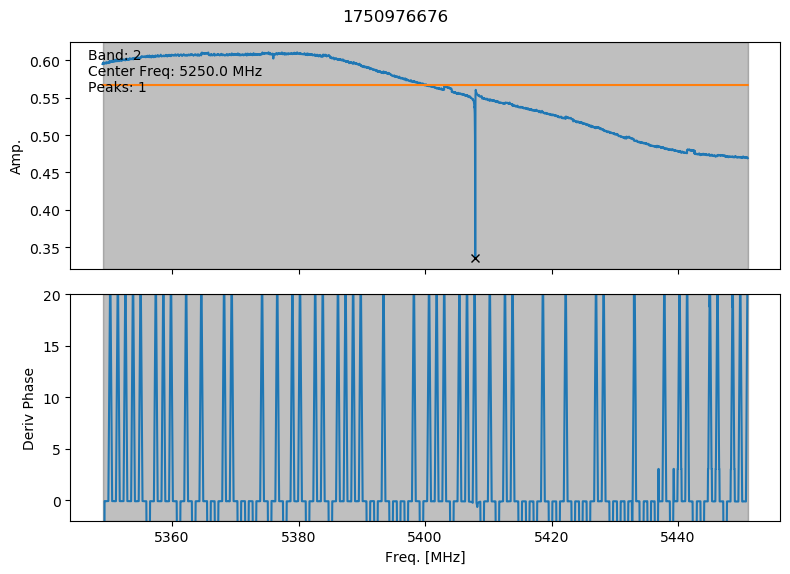

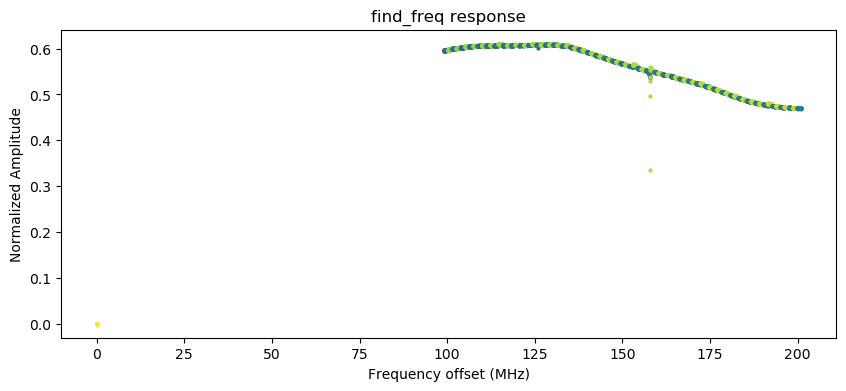

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]]))

In [120]:

S.find_freq(2,tone_power=14,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


In [122]:
?S.take_stream_data

Signature:
S.take_stream_data(
    meas_time,
    downsample_factor=None,
    write_log=True,
    update_payload_size=True,
    reset_unwrapper=True,
    reset_filter=True,
    return_data=False,
    make_freq_mask=True,
    register_file=False,
)
Docstring:
Takes streaming data for a given amount of time

To do: move downsample_factor to config table

Args
----
meas_time : float
    The amount of time to observe for in seconds.
downsample_factor : int or None, optional, default None
    The number of fast sample (the flux ramp reset rate -
    typically 4kHz) to skip between reporting. If None, does
    not update.
write_log : bool, optional, default True
    Whether to write to the log file.
update_payload_size : bool, optional, default True
    Whether to update the payload size (the number of channels
    written to disk). If the number of channels on is greater
    than the payload size, then only the first N channels are
    written. This bool will update the payload size to be t

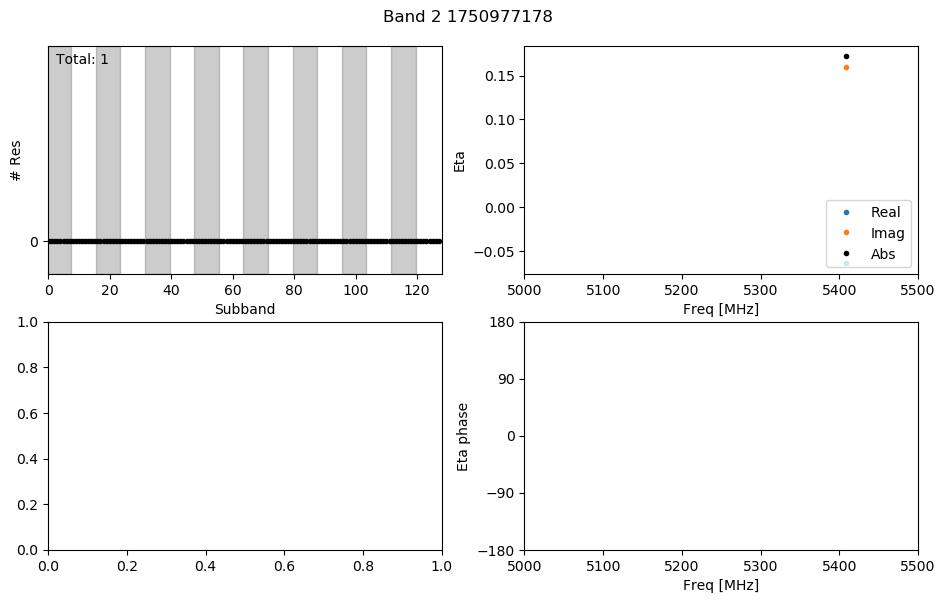

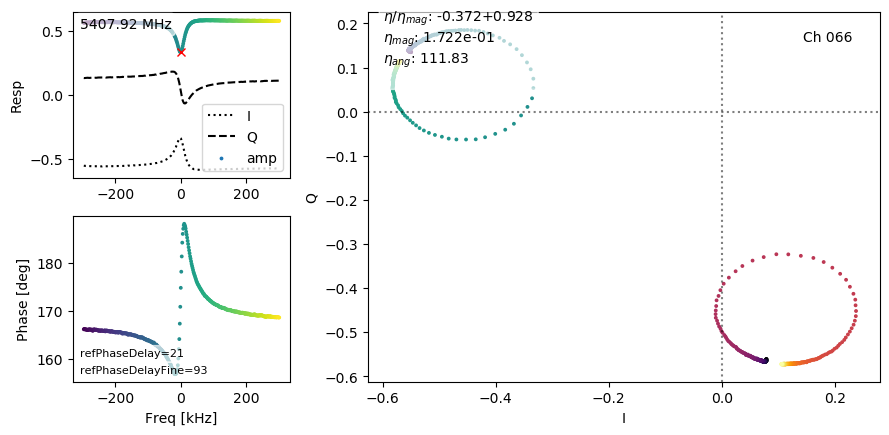

In [123]:

S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)

writeMessage2Splendaq(coms_file_name, f'turn LED ON:{2.7}:{1.5}') 
sleep(10)
filename = S.take_stream_data(3)

In [137]:
S.get_feedback_enable_array(2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [127]:
t, d, m = S.read_stream_data(filename)

Processing data records from /data/smurf_data/20250626/1750957495/outputs/1750977193.dat
Processed 606 data records from /data/smurf_data/20250626/1750957495/outputs/1750977193.dat
Processed a total of 606 data records


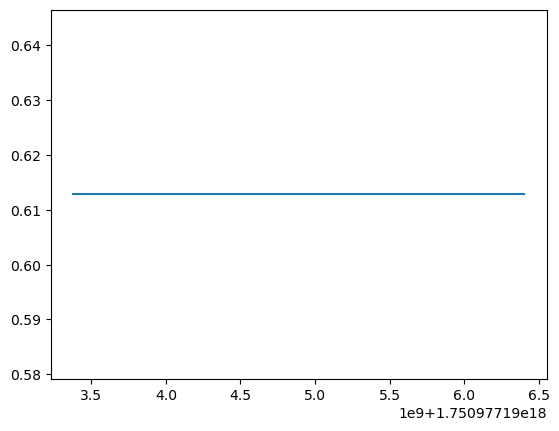

In [132]:
plt.plot(t, d[0])

In [141]:
S.set_feedback_enable_channel(2,66,0)

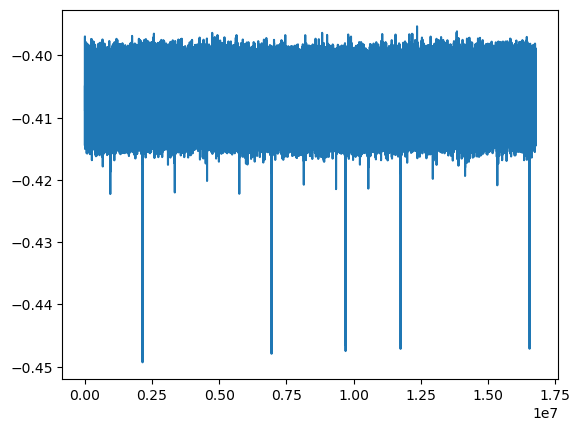

In [142]:
channel = S.which_on(2)[0]
timestamp = S.get_timestamp() 
channel = S.which_on(BAND)[0]
filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=2**24,filename=filename, single_channel_readout=2)

plt.plot(i)

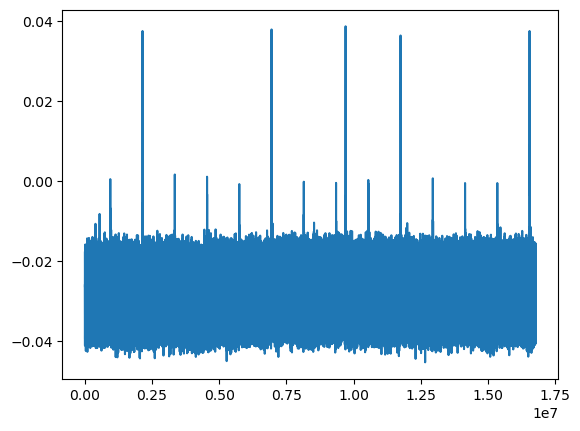

In [143]:
plt.plot(q)

In [146]:
S.flux_ramp_setup(reset_rate_khz=4,fraction_full_scale=0)

In [147]:
S.set_feedback_enable_channel(2, 66, 1)

Processing data records from /data/smurf_data/20250626/1750957495/outputs/1750977813.dat
Processed 601 data records from /data/smurf_data/20250626/1750957495/outputs/1750977813.dat
Processed a total of 601 data records


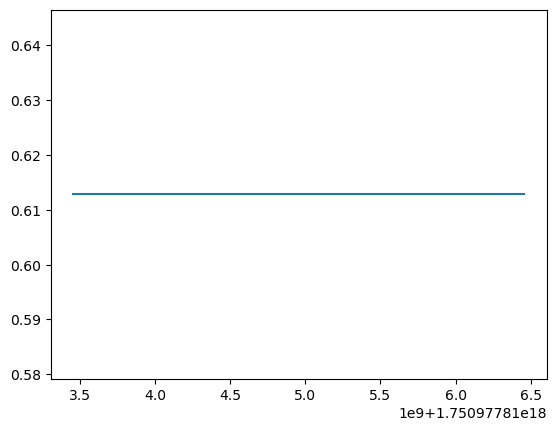

In [148]:

S.flux_ramp_setup(reset_rate_khz=4,fraction_full_scale=0)
filename = S.take_stream_data(3)
t, d, m = S.read_stream_data(filename)

plt.plot(t, d[0])

In [150]:
file_path = S.stream_data_on(downsample_factor=None,
                update_payload_size=True, write_log=True,
                reset_unwrapper=True, reset_filter=True,
                make_freq_mask=True)
sleep(2)
S.stream_data_off(write_log=True, register_file=False)



Processing data records from /data/smurf_data/20250626/1750957495/outputs/1750978643.dat
Processed 403 data records from /data/smurf_data/20250626/1750957495/outputs/1750978643.dat
Processed a total of 403 data records


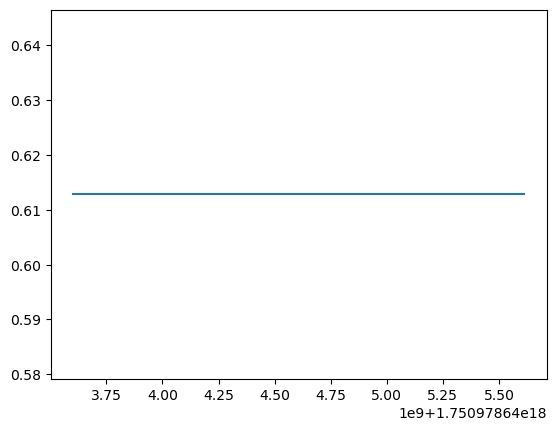

In [151]:

t, d, m = S.read_stream_data(file_path)
plt.plot(t, d[0])

In [152]:
S.which_on(2)

array([66])

In [153]:
S.get_feedback_enable_channel(2,66)

1

In [154]:
?S.tracking_setup

Signature:
S.tracking_setup(
    band,
    channel=None,
    reset_rate_khz=None,
    write_log=False,
    make_plot=False,
    save_plot=True,
    show_plot=True,
    nsamp=524288,
    lms_freq_hz=None,
    meas_lms_freq=False,
    meas_flux_ramp_amp=False,
    n_phi0=4,
    flux_ramp=True,
    fraction_full_scale=None,
    lms_enable1=True,
    lms_enable2=True,
    lms_enable3=True,
    feedback_gain=None,
    lms_gain=None,
    return_data=True,
    new_epics_root=None,
    feedback_start_frac=None,
    feedback_end_frac=None,
    setup_flux_ramp=True,
    plotname_append='',
)
Docstring:
The function to start tracking. Starts the flux ramp and if requested
attempts to measure the lms (demodulation) frequency. Otherwise this
just tracks at the input lms frequency. This will also make plots for
the channels listed in {channel} input.

Args
----
band : int
    The band number.
channel : int or int array or None, optional, default None
    The channels to plot.
reset_rate_khz : float 

In [155]:
S.which_on(2)

array([66])

In [156]:
S.channel_off(2,66)

In [157]:
filename = S.take_stream_data(3)

In [158]:
t, d, m = S.read_stream_data(filename)

Processing data records from /data/smurf_data/20250626/1750957495/outputs/1751041831.dat
Processed 601 data records from /data/smurf_data/20250626/1750957495/outputs/1751041831.dat
Processed a total of 601 data records


/usr/local/src/pysmurf/python/pysmurf/client/util/smurf_util.py:1413: UserWarning: loadtxt: input contained no data: "/data/smurf_data/20250626/1750957495/outputs/1751041831_mask.txt"
  mask = np.atleast_1d(np.loadtxt(mask_file))


ValueError: zero-size array to reduction operation maximum which has no identity

In [160]:
print(len(d[0]))

403


In [161]:

S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)

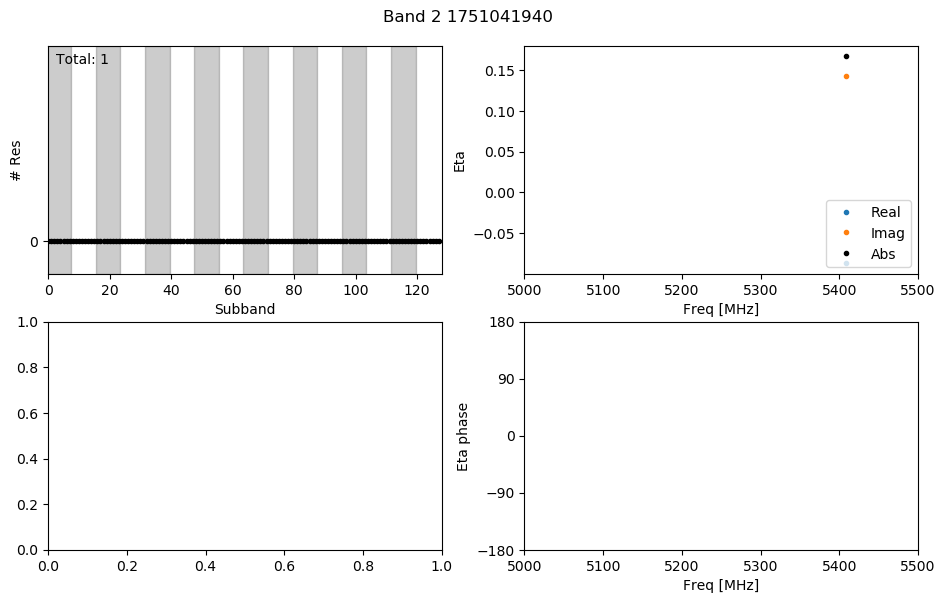

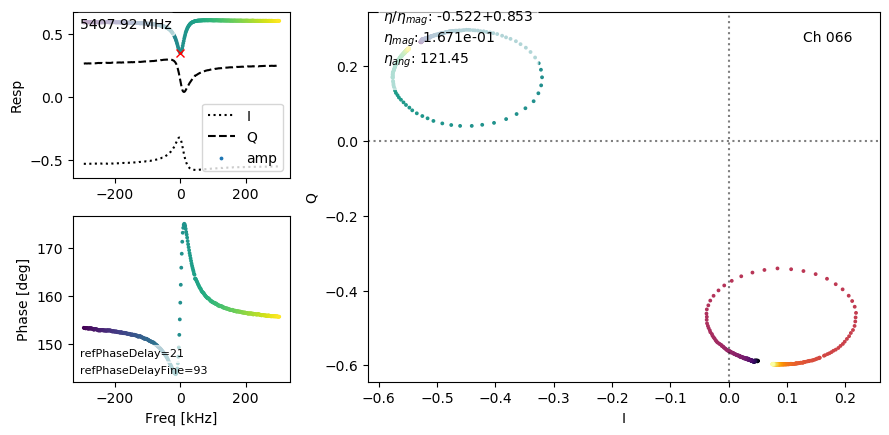

In [162]:
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)


In [163]:
?S.take_stream_data

Signature:
S.take_stream_data(
    meas_time,
    downsample_factor=None,
    write_log=True,
    update_payload_size=True,
    reset_unwrapper=True,
    reset_filter=True,
    return_data=False,
    make_freq_mask=True,
    register_file=False,
)
Docstring:
Takes streaming data for a given amount of time

To do: move downsample_factor to config table

Args
----
meas_time : float
    The amount of time to observe for in seconds.
downsample_factor : int or None, optional, default None
    The number of fast sample (the flux ramp reset rate -
    typically 4kHz) to skip between reporting. If None, does
    not update.
write_log : bool, optional, default True
    Whether to write to the log file.
update_payload_size : bool, optional, default True
    Whether to update the payload size (the number of channels
    written to disk). If the number of channels on is greater
    than the payload size, then only the first N channels are
    written. This bool will update the payload size to be t

In [164]:
filename = S.take_stream_data(3)

Processing data records from /data/smurf_data/20250626/1750957495/outputs/1751041977.dat
Processed 601 data records from /data/smurf_data/20250626/1750957495/outputs/1751041977.dat
Processed a total of 601 data records
(1, 601)


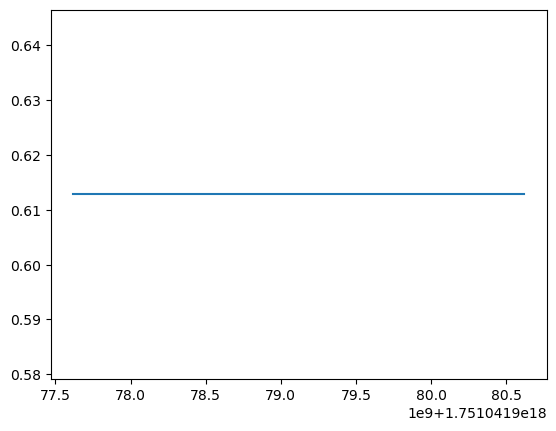

In [165]:
t, d, m = S.read_stream_data(filename)
plt.plot(t, d[0])
print(np.shape(d))

In [166]:
S.get_feedback_enable_array(2)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [167]:
S.get_feedback_enable(2)

1

In [169]:
S.set_feedback_enable_channel(2, 66, 0)

Processing data records from /data/smurf_data/20250626/1750957495/outputs/1751042132.dat
Processed 601 data records from /data/smurf_data/20250626/1750957495/outputs/1751042132.dat
Processed a total of 601 data records
(1, 601)


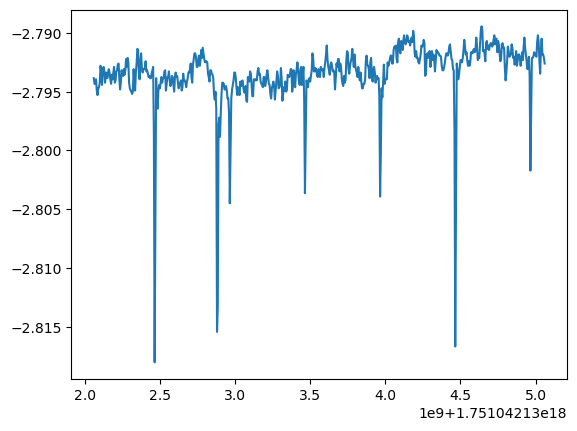

In [171]:
filename = S.take_stream_data(3)
t, d, m = S.read_stream_data(filename)
plt.plot(t, d[0])
print(np.shape(d))

In [173]:
S.get_eta_phase_array(2)

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [174]:
  3e-7 * 5.4e9

1620.0

In [177]:
get_freq_in_Hz(S, 2, 66)

5407915500.068665

In [208]:

writeMessage2Splendaq(coms_file_name, f'turn LED OFF') 

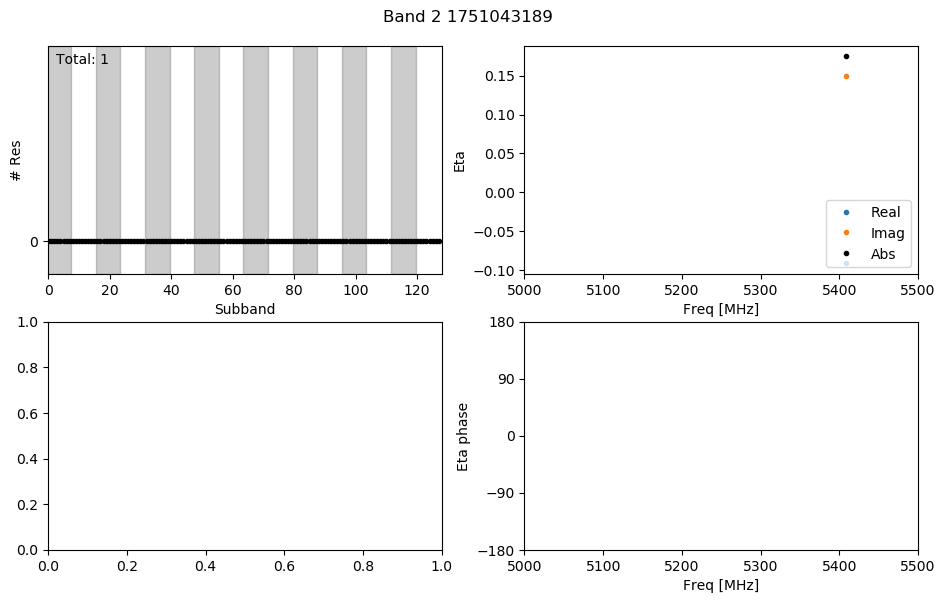

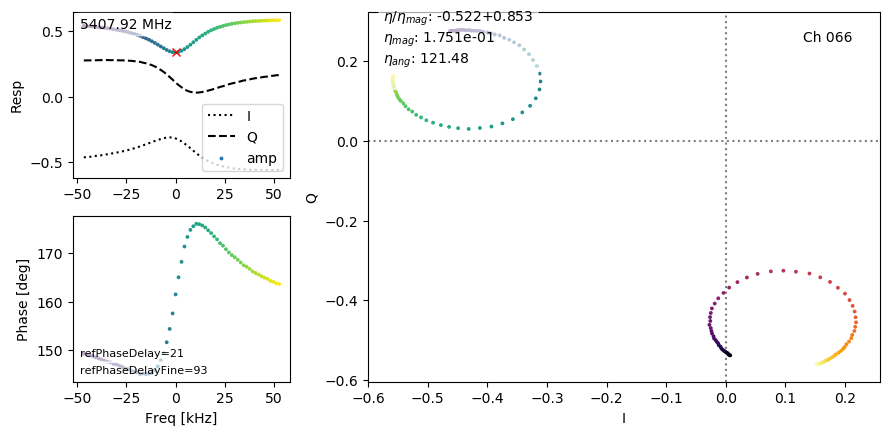

In [188]:

S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True,sweep_width=0.05)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)

writeMessage2Splendaq(coms_file_name, f'turn LED ON:{2.7}:{1.5}') 


In [189]:
filename = S.take_stream_data(3)

In [192]:
S.toggle_feedback(2)

Processing data records from /data/smurf_data/20250626/1750957495/outputs/1751043211.dat
Processed 601 data records from /data/smurf_data/20250626/1750957495/outputs/1751043211.dat
Processed a total of 601 data records


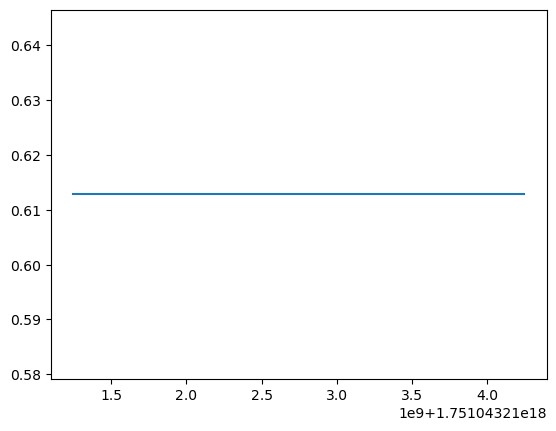

In [193]:
t, d, m = S.read_stream_data(filename)
plt.plot(t, d[0])

In [194]:
print(d)

[[0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.61282532 0.61282532
  0.61282532 0.61282532 0.61282532 0.61282532 0.

In [198]:
S.run_serial_gradient_descent(2)
S.run_serial_eta_scan(2)

Text(0, 0.5, 'Frequency error (MHz)')

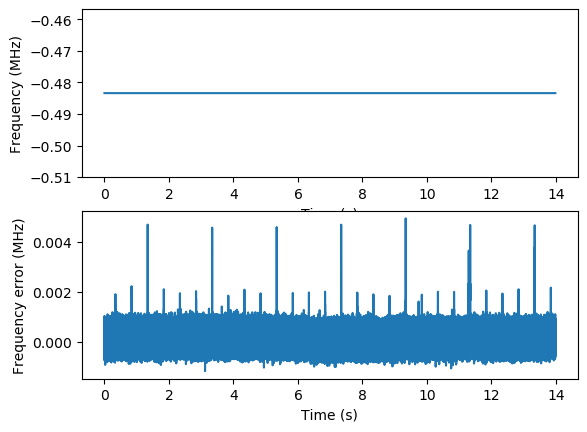

In [199]:
S.set_feedback_enable(band=2, val=0)
channel = 66
fs = 2.4e6
f, df, sync = S.take_debug_data(band=2, channel=channel, nsamp=2**25, IQstream=0, single_channel_readout=2)
t = np.arange(len(df))/fs
plt.subplot(211)
plt.plot(t, f)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.subplot(212)
plt.plot(t, df)
plt.xlabel('Time (s)')
plt.ylabel('Frequency error (MHz)')

Text(0, 0.5, 'Frequency error (MHz)')

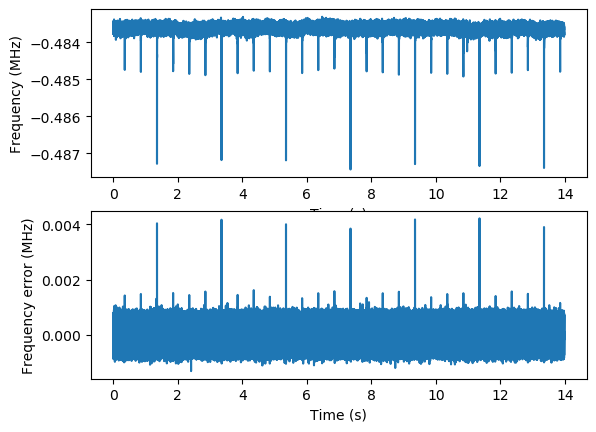

In [200]:
S.set_feedback_enable(band=2, val=1)
channel = 66
fs = 2.4e6
f, df, sync = S.take_debug_data(band=2, channel=channel, nsamp=2**25, IQstream=0, single_channel_readout=2)
t = np.arange(len(df))/fs
plt.subplot(211)
plt.plot(t, f)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.subplot(212)
plt.plot(t, df)
plt.xlabel('Time (s)')
plt.ylabel('Frequency error (MHz)')

Holy shit, we did it, we're champions.   Let's see if we can better track the pulses.  I think? that these regs control the servo gain ; although they have a confusing relationship that I can't remember.  I think they're basically degenerate, and it's better to adjust `feedbackGain` if you don't have to adjust `lmsGain`, but we'll have to play with it if we get serious about this.  Let's try just upping `feedbackGain`;

In [204]:
print(f'feedback_gain = {S.get_feedback_gain(BAND)}')
print(f'lms_gain = {S.get_lms_gain(BAND)}')

feedback_gain = 2048
lms_gain = 1


Text(0, 0.5, 'Frequency error (MHz)')

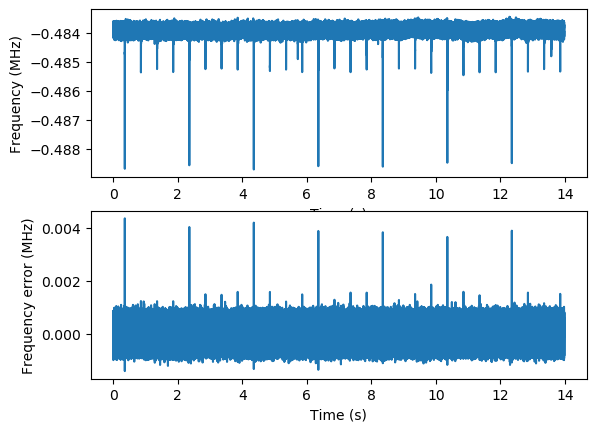

In [206]:
S.set_feedback_enable(band=2, val=1)
channel = 66
fs = 2.4e6
f, df, sync = S.take_debug_data(band=2, channel=channel, nsamp=2**25, IQstream=0, single_channel_readout=2)
t = np.arange(len(df))/fs
plt.subplot(211)
plt.plot(t, f)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.subplot(212)
plt.plot(t, df)
plt.xlabel('Time (s)')
plt.ylabel('Frequency error (MHz)')

In [205]:
S.set_feedback_gain(BAND,4096) #double it

In [184]:
S.get_feedback_limit(2)

6144

In [185]:
S.get_feedback_gain(2)

2048

In [201]:
?S.take_stream_data

Signature:
S.take_stream_data(
    meas_time,
    downsample_factor=None,
    write_log=True,
    update_payload_size=True,
    reset_unwrapper=True,
    reset_filter=True,
    return_data=False,
    make_freq_mask=True,
    register_file=False,
)
Docstring:
Takes streaming data for a given amount of time

To do: move downsample_factor to config table

Args
----
meas_time : float
    The amount of time to observe for in seconds.
downsample_factor : int or None, optional, default None
    The number of fast sample (the flux ramp reset rate -
    typically 4kHz) to skip between reporting. If None, does
    not update.
write_log : bool, optional, default True
    Whether to write to the log file.
update_payload_size : bool, optional, default True
    Whether to update the payload size (the number of channels
    written to disk). If the number of channels on is greater
    than the payload size, then only the first N channels are
    written. This bool will update the payload size to be t

In [207]:
S.which_on(2)

array([66])

## Lets get something useful for Shawn

/data/smurf_data/20250626/1750957495/outputs/1750957495.log


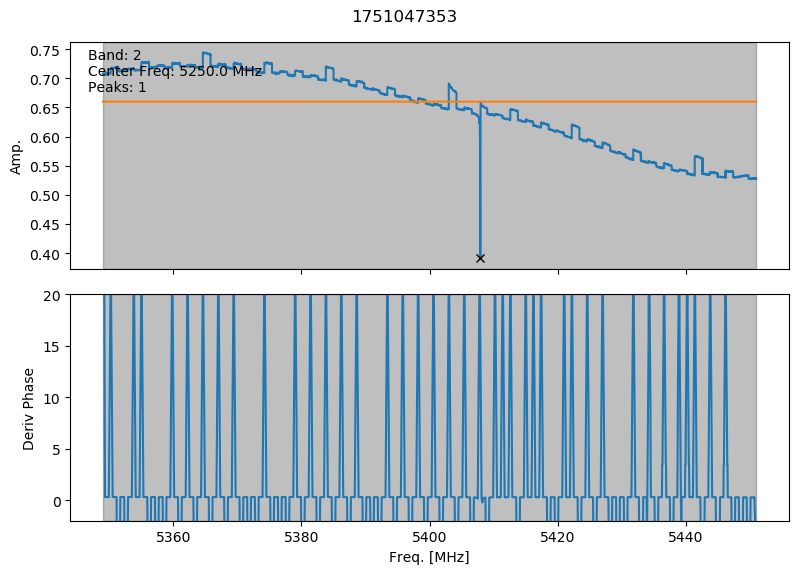

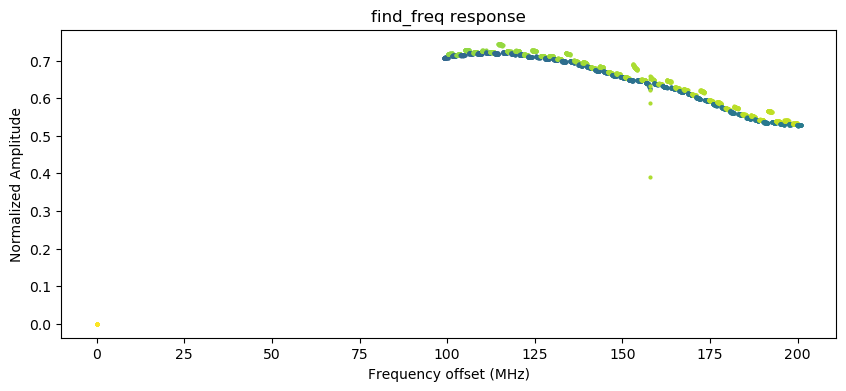

/data/smurf_data/tune/1751047368_tune.npy
Fr from fit  [GHz]: 5407.919971876167
Fr min curve [GHz]: 5407.917
Fit dictionary parameters:   {'f0': 5407.919971876167, 'Qr': 160079.59897872826, 'phi': -0.31989864479012864, 'zOff': (-0.7213371423537432+0.3199359884333569j), 'QcHat': 374835.7311411578, 'tau': (0.00046875187956685755+0.00040468539311125834j), 'Qc': 394868.47661865054}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


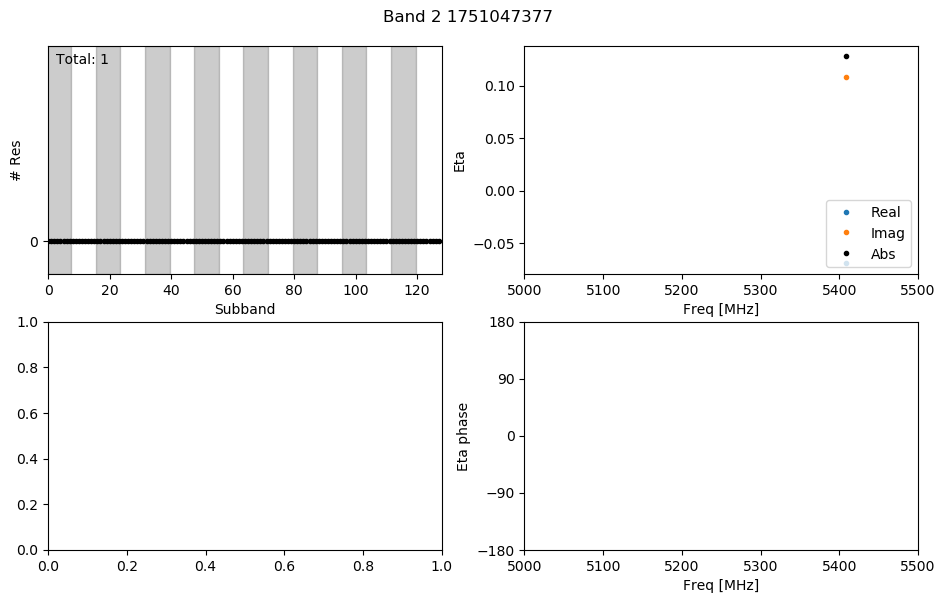

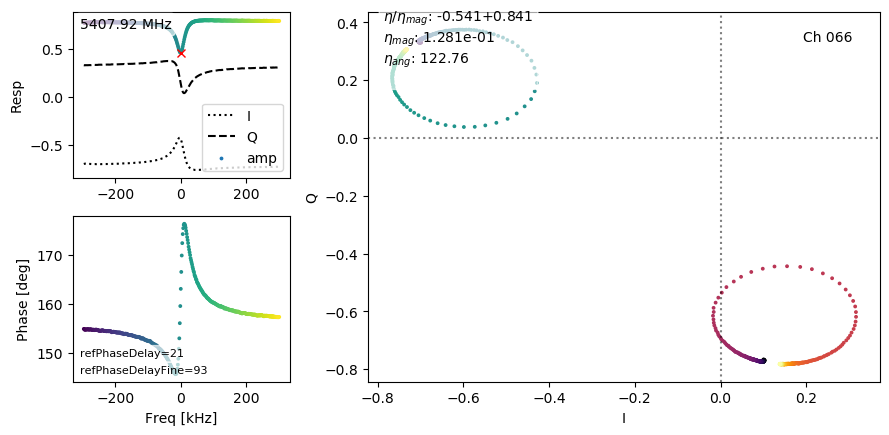

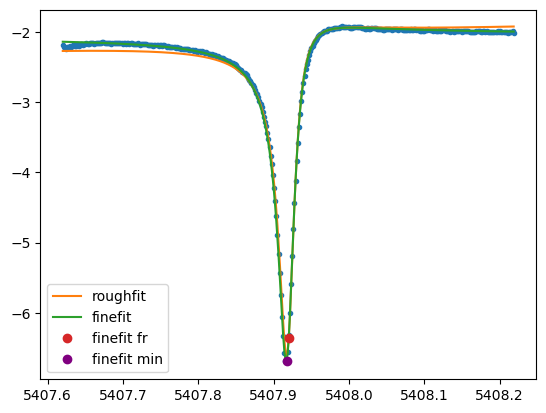

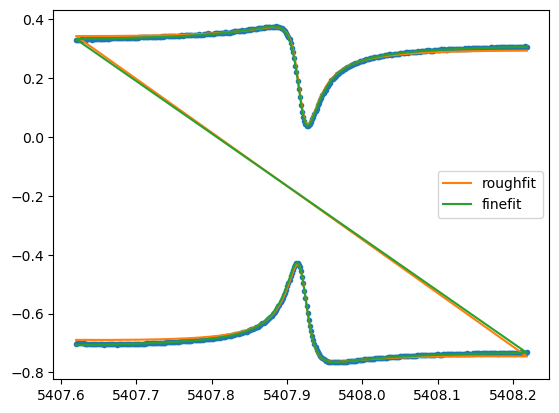

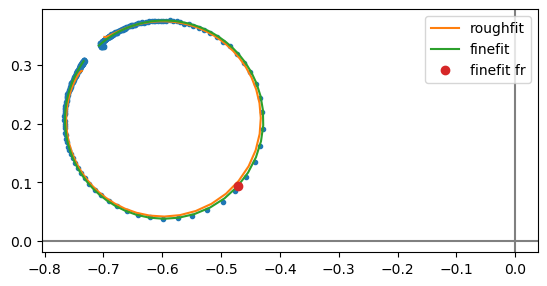

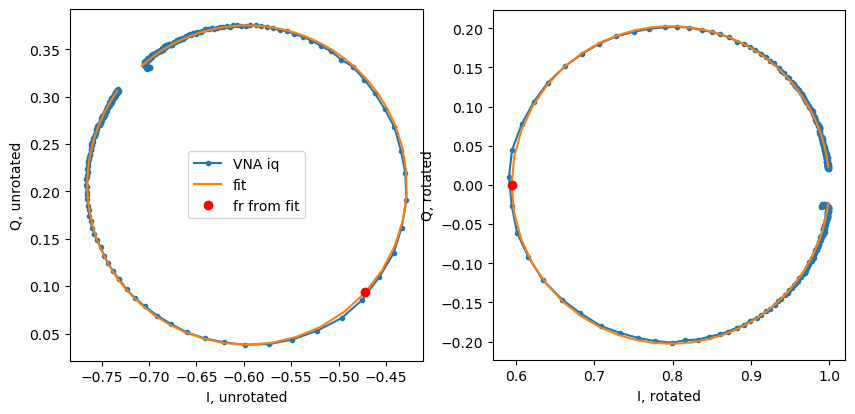

TIME: 1751047382
running char tones
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!


In [219]:

print( S.log.logfile.name)
TONE_POWER = 15

CH_GUESS = 66

NSAMP = 2**25

CHAN_MODE  = 2

NSAMP_CHAR = 2**15

CHAR_OFFSETS = [-0.2, -.1, 0, .1, 0.2]


ITERATIONS = 1

COOLDOWN = 'Olaf18'

DECIMATION = 0
FILTER_CUTOFF=2.4e6

F_OFF_RES = 5415 


LED_settings = {}



RF_settings = {'chain': ['Smurf out',\
               'LNF-LNR1_15B_SV',\
               '20 dB',\
               'C0', COOLDOWN, 'A2',\
               'ZX60-05113LN+',\
               '3 dB',\
               'ZX60-83LN-S+',\
                'ZFSC-2-10G+',\
               'Smurf in']}


AWG_settings = {}



## decide on decimation and filtering

S.find_freq(2,tone_power=13,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)
print(S.tune_file)

tune_dict=load_tune_file(S.tune_file, BAND)


S.set_feedback_enable_channel(BAND,CH_GUESS,0)
    
for ch in S.which_on(BAND):
    S.channel_off(BAND, ch)
    
    
fit_dict, fine_errs = fit_data(S.tune_file, BAND, plot=True)
char_offset_scale = fit_dict['f0'] / fit_dict['Qr'] 

plt.show()



#S.set_decimation(BAND, DECIMATION)
#S.set_debug_data_filter_cutoff(BAND, FILTER_CUTOFF)


file_list = []
MEMS_settings = {'mirror_position':[0,0], 'mirror_params':(90, 169, 120)}
    
for ii in range(ITERATIONS):
    print('TIME:', S.get_timestamp())    
    char_avgs = {}
    print('running char tones')
    for f_offs in CHAR_OFFSETS:
        new_freq = fit_dict['f0'] + char_offset_scale * f_offs 
        S.set_fixed_tone(new_freq, TONE_POWER)
        timestamp = S.get_timestamp() 
        channel = S.which_on(BAND)[0]
        filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
        i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP_CHAR,filename=filename, single_channel_readout=CHAN_MODE)
        avg = np.mean(i+1j*q)
        char_avgs[new_freq] = [avg.real, avg.imag]
        for ch in S.which_on(BAND):
            S.channel_off(BAND, ch)


   


    print('taking real data')
    S.set_fixed_tone(fit_dict['f0'], TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    

    print('taking real data')
    S.set_fixed_tone(F_OFF_RES, TONE_POWER, write_log=True)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    


In [220]:
print(f"logfile = '{S.log.logfile.name}'")
print(f"directory_path_rfsoc = '{'/'.join(S.log.logfile.name.split('/')[0:-1])}/'")
print(f"rfsoc_tune_file = '{S.tune_file}'")
print('rfsoc_file_list = ',file_list)

logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1751047368_tune.npy'
rfsoc_file_list =  ['1751047396_single_channel_b2ch066', '1751047436_single_channel_b2ch290']


-5.0067847657538715
-0.8306020986471436
-6.088728520643934
-2.1637737842620375


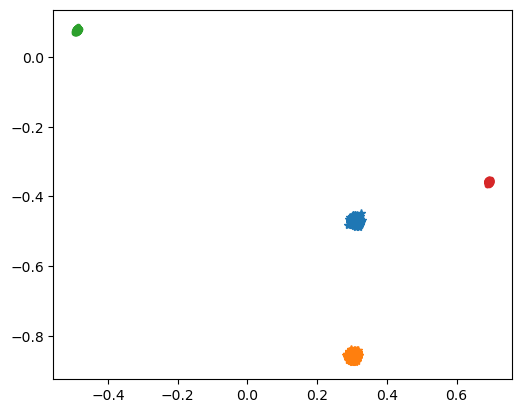

In [221]:
# these files are from the crate :
logfile_crate = '/data/smurf_data/20250624/1750806949/outputs/1750806949.log'
directory_path_crate = '/data/smurf_data/20250624/1750806949/outputs/'
crate_tune_file = '/data/smurf_data/tune/1750808478_tune.npy'
crate_file_list =  ['1750808504_single_channel_b2ch066', '1750808528_single_channel_b2ch290']

# these files are from the rfsoc: 

logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1751047368_tune.npy'
rfsoc_file_list =  ['1751047396_single_channel_b2ch066', '1751047436_single_channel_b2ch290']

# now load them all, and make them 

# plot tune file 
for file in crate_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_crate+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='*', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(np.mean(power_db))


for file in rfsoc_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='.', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(np.mean(power_db))

plt.gca().set_aspect('equal')



In [216]:
3e-7 * 5.408*1e9

1622.4

In [222]:
-5.006 - - 0.8306

-4.2

In [224]:
-6.088 - -2.164

-3.924

/data/smurf_data/20250626/1750957495/outputs/1750957495.log


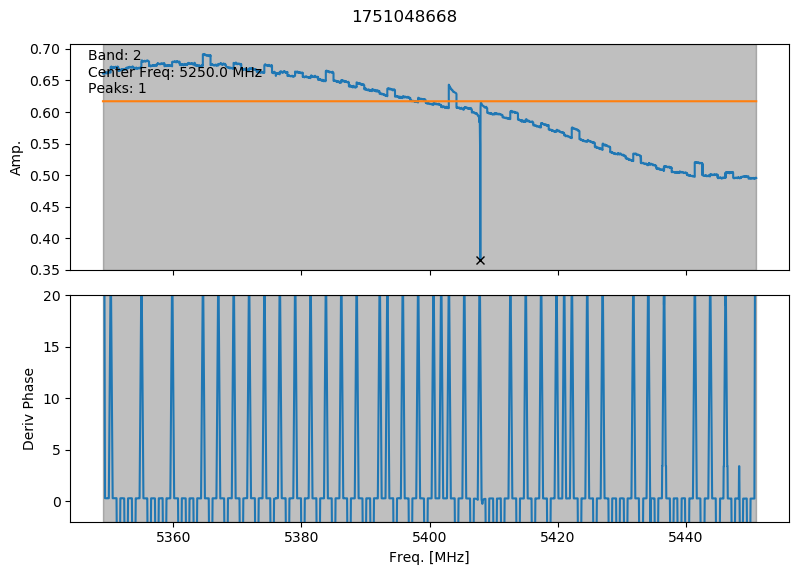

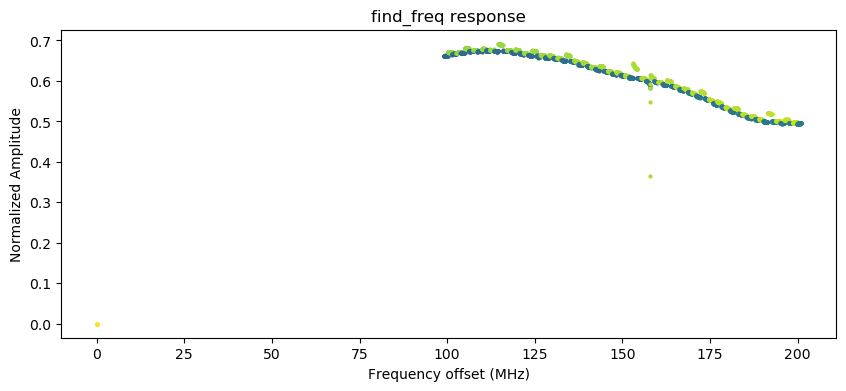

/data/smurf_data/tune/1751048683_tune.npy
Fr from fit  [GHz]: 5407.919897236585
Fr min curve [GHz]: 5407.917
Fit dictionary parameters:   {'f0': 5407.919897236585, 'Qr': 159771.43674167705, 'phi': -0.3216522924157715, 'zOff': (-0.6832216647097128+0.294415222356973j), 'QcHat': 373745.0281049697, 'tau': (0.0009276086389893553+0.00033800921043879124j), 'Qc': 393948.94949229463}
Plotting iq, fit, and fr in ideal basis
Plotting iq, fit, and fr in resonator basis


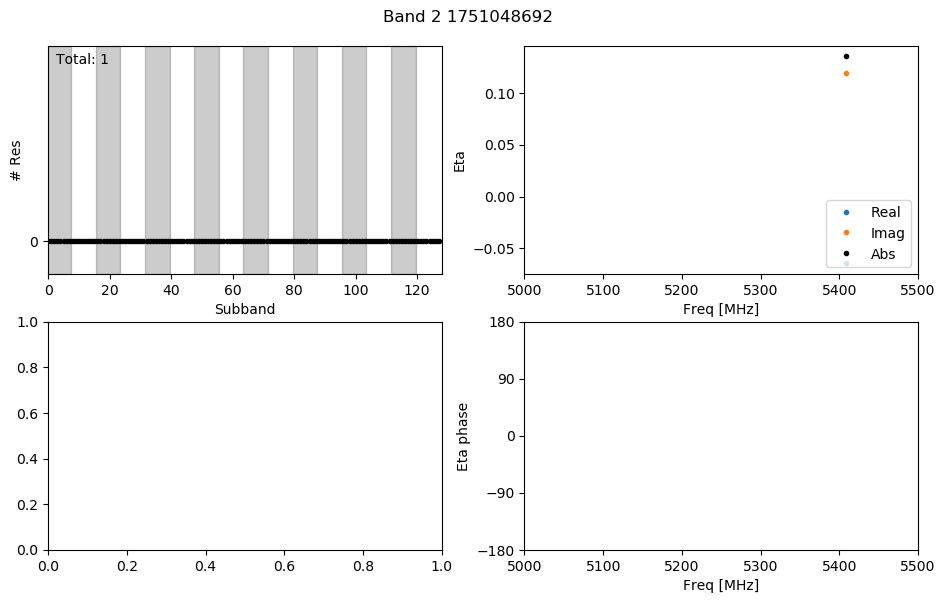

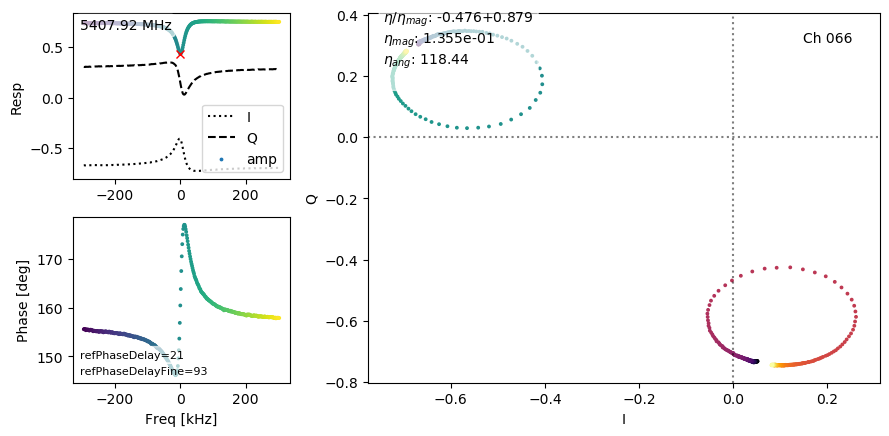

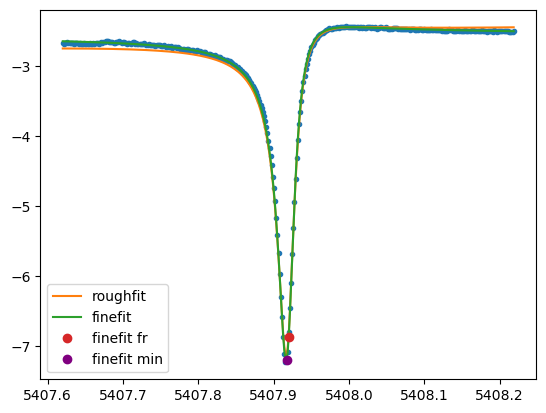

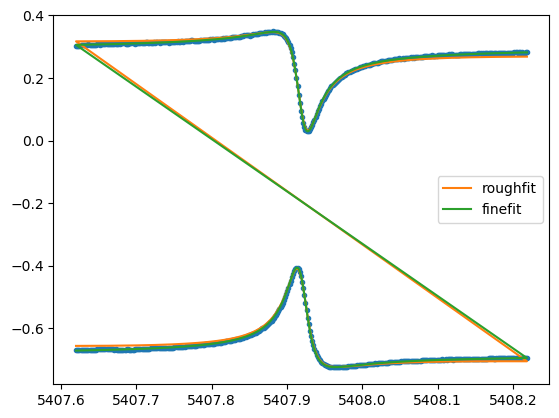

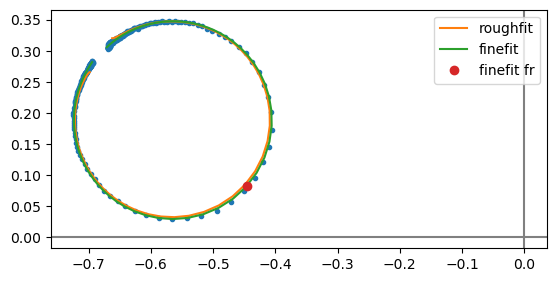

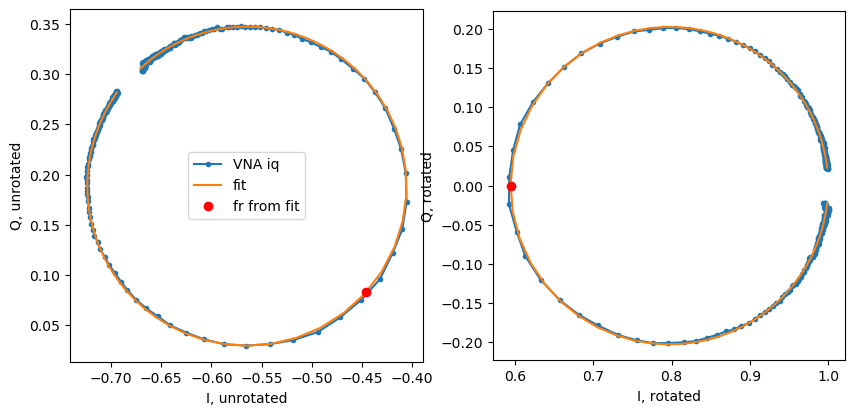

TIME: 1751048697
running char tones
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!
taking real data
Function get_att_uc called, but not implemented on RFSoC.  Skipping call and returning None!
Function get_att_dc called, but not implemented on RFSoC.  Skipping call and returning None!


In [229]:

print( S.log.logfile.name)
TONE_POWER = 15

CH_GUESS = 66

NSAMP = 2**25

CHAN_MODE  = 2

NSAMP_CHAR = 2**15

CHAR_OFFSETS = [-0.2, -.1, 0, .1, 0.2]


ITERATIONS = 1

COOLDOWN = 'Olaf18'

DECIMATION = 0
FILTER_CUTOFF=2.4e6

F_OFF_RES = 5415 


LED_settings = {}



RF_settings = {'chain': ['Smurf out',\
               'LNF-LNR1_15B_SV',\
               '20 dB',\
               'C0', COOLDOWN, 'A2',\
               'ZX60-05113LN+',\
               '0 dB',\
               'ZX60-83LN-S+',\
                'ZFSC-2-10G+',\
               'Smurf in']}


AWG_settings = {}



## decide on decimation and filtering

S.find_freq(2,tone_power=13,\
                start_freq=100,stop_freq=200,make_plot=True,show_plot=True,\
                amp_cut=0.1,grad_cut=-1e9,rolling_med=False) #amp cut decides what you count for a resonator 


S.setup_notches(BAND,tone_power=TONE_POWER, df_sweep=0.0015, new_master_assignment=True)
S.plot_tune_summary(BAND,eta_scan=True,show_plot=True)
print(S.tune_file)

tune_dict=load_tune_file(S.tune_file, BAND)


S.set_feedback_enable_channel(BAND,CH_GUESS,0)
    
for ch in S.which_on(BAND):
    S.channel_off(BAND, ch)
    
    
fit_dict, fine_errs = fit_data(S.tune_file, BAND, plot=True)
char_offset_scale = fit_dict['f0'] / fit_dict['Qr'] 

plt.show()



#S.set_decimation(BAND, DECIMATION)
#S.set_debug_data_filter_cutoff(BAND, FILTER_CUTOFF)


file_list = []
MEMS_settings = {'mirror_position':[0,0], 'mirror_params':(90, 169, 120)}
    
for ii in range(ITERATIONS):
    print('TIME:', S.get_timestamp())    
    char_avgs = {}
    print('running char tones')
    for f_offs in CHAR_OFFSETS:
        new_freq = fit_dict['f0'] + char_offset_scale * f_offs 
        S.set_fixed_tone(new_freq, TONE_POWER)
        sleep(2)
        timestamp = S.get_timestamp() 
        channel = S.which_on(BAND)[0]
        filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
        i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP_CHAR,filename=filename, single_channel_readout=CHAN_MODE)
        avg = np.mean(i+1j*q)
        char_avgs[new_freq] = [avg.real, avg.imag]
        for ch in S.which_on(BAND):
            S.channel_off(BAND, ch)


   


    print('taking real data')
    S.set_fixed_tone(fit_dict['f0'], TONE_POWER, write_log=True)
    sleep(2)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    

    print('taking real data')
    S.set_fixed_tone(F_OFF_RES, TONE_POWER, write_log=True)
    sleep(2)
    timestamp = S.get_timestamp() 
    channel =S.which_on(BAND)[0]
    filename = f'{timestamp}_single_channel_b{BAND}ch{channel:03}'
    i,q,sync = S.take_debug_data(band=BAND,channel=channel,rf_iq=True,nsamp=NSAMP,filename=filename, single_channel_readout=CHAN_MODE)
    S.channel_off(BAND,channel)
    ## log debug data 
    file_list.append(filename)
    #TODO get this into shape
    TESTlogDebugData(S, band=BAND,\
                         reschannel=channel,\
                         nsamp=NSAMP,\
                         sync=sync,\
                         filename=filename,\
                         tunefile=S.tune_file,\
                         cooldown_str=COOLDOWN,\
                         decimation=DECIMATION,\
                         filter_f3db=FILTER_CUTOFF,\
                         channel_mode=CHAN_MODE,\
                         char_avgs=char_avgs,\
                         awg_settings=AWG_settings,\
                         led_settings=LED_settings,\
                         MEMS_settings=MEMS_settings,\
                         rf_settings=RF_settings,\
                            fit_dict=fit_dict)
    


In [230]:
print(f"logfile = '{S.log.logfile.name}'")
print(f"directory_path_rfsoc = '{'/'.join(S.log.logfile.name.split('/')[0:-1])}/'")
print(f"rfsoc_tune_file = '{S.tune_file}'")
print('rfsoc_file_list = ',file_list)

logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1751048683_tune.npy'
rfsoc_file_list =  ['1751048723_single_channel_b2ch066', '1751048750_single_channel_b2ch290']


-5.0067847657538715
-0.8306020986471436
-6.623682503617637
-2.71374814043477


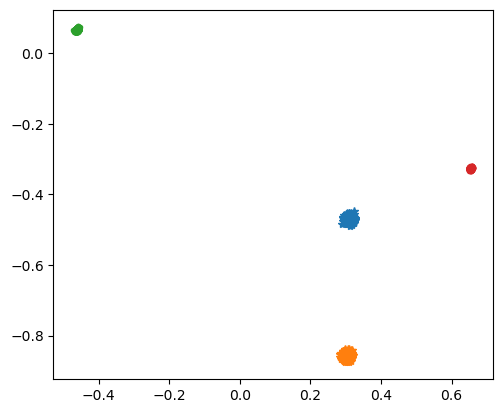

In [231]:
# these files are from the crate :
logfile_crate = '/data/smurf_data/20250624/1750806949/outputs/1750806949.log'
directory_path_crate = '/data/smurf_data/20250624/1750806949/outputs/'
crate_tune_file = '/data/smurf_data/tune/1750808478_tune.npy'
crate_file_list =  ['1750808504_single_channel_b2ch066', '1750808528_single_channel_b2ch290']

# these files are from the rfsoc: 
logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1751048683_tune.npy'
rfsoc_file_list =  ['1751048723_single_channel_b2ch066', '1751048750_single_channel_b2ch290']


# now load them all, and make them 

# plot tune file 
for file in crate_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_crate+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='*', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(np.mean(power_db))


for file in rfsoc_file_list: 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    # plot i and q in a specific color 
    plt.plot(i[0:1000], q[0:1000], marker='.', linestyle='')
    power = i**2 + q**2
    power_db = 10 * np.log10(power + 1e-12)
    print(np.mean(power_db))

plt.gca().set_aspect('equal')



In [ ]:
# now instead of just overplotting the IQ blobs, lets take some PSDs: 


In [236]:
from scipy import signal

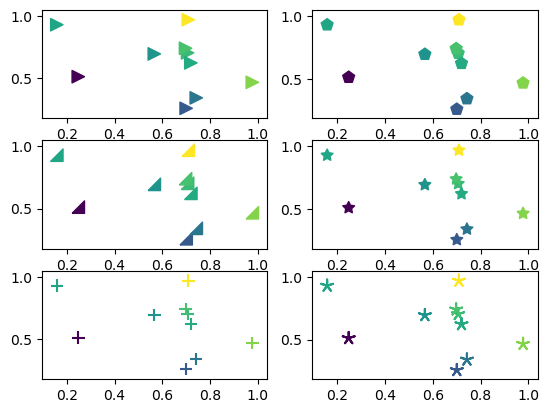

In [247]:
np.random.seed(19680801)


x = np.random.rand(10)
y = np.random.rand(10)
z = np.sqrt(x**2 + y**2)

plt.subplot(321)
plt.scatter(x, y, s=80, c=z, marker=">")

plt.subplot(322)
plt.scatter(x, y, s=80, c=z, marker=(5, 0))

verts = np.array([[-1, -1], [1, -1], [1, 1], [-1, -1]])
plt.subplot(323)
plt.scatter(x, y, s=80, c=z, marker=verts)

plt.subplot(324)
plt.scatter(x, y, s=80, c=z, marker=(5, 1))

plt.subplot(325)
plt.scatter(x, y, s=80, c=z, marker='+')

plt.subplot(326)
plt.scatter(x, y, s=80, c=z, marker=(5, 2))

plt.show()



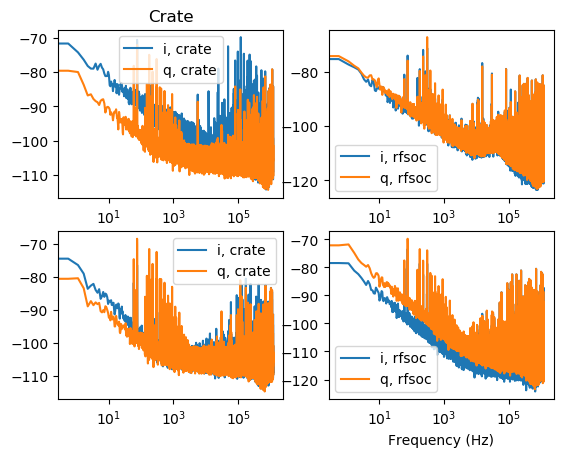

In [255]:
fig, axs = plt.subplots(2,2)
for e, file in enumerate(crate_file_list): 
    if e == 0: yaxis = 'On Resonance'
    else: yaxis='Off Resonance'
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_crate+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    freq, pxx = signal.welch(i, nperseg=len(i)/8, fs=fs)
    axs[e,0].semilogx(freq, 10*np.log10(pxx),label='i, crate')
    #axs[e,0].set_xlabel('Frequency (Hz)')
    #axs[e,0].set_ylabel(yaxis)
    
    freq, pxx = signal.welch(q, nperseg=len(q)/8, fs=fs)
    axs[e,0].semilogx(freq, 10*np.log10(pxx),label='q, crate')
    #axs[e,0].set_xlabel('Frequency (Hz)')
    #axs[e,0].set_ylabel(yaxis)

axs[0,0].set_title('Crate')
for e, file in enumerate(rfsoc_file_list): 
    if e == 0: yaxis = 'On Resonance'
    else: yaxis='Off Resonance'
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    #convert i and q 
    i = i/1.2
    q = q/(-1.2)
    freq, pxx = signal.welch(i, nperseg=len(i)/8, fs=fs)
    axs[e,1].semilogx(freq, 10*np.log10(pxx),label='i, rfsoc')
    axs[e,1].set_xlabel('Frequency (Hz)')
    #axs[e,1].set_ylabel(yaxis)
    
    freq, pxx = signal.welch(q, nperseg=len(q)/8, fs=fs)
    axs[e,1].semilogx(freq, 10*np.log10(pxx),label='q, rfsoc')
    axs[e,1].set_xlabel('Frequency (Hz)')
    #axs[e,1].set_ylabel(yaxis)
#axs[0,0].set_title('Crate')
#axs[0,1].set_title('RFsoc')
axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()


well that SUCKS

what if we did a better job making our PSDs...

In [6]:
S = pysmurf.client.SmurfControl(offline=True)



[ 2025-07-01 20:55:14 ]  Offline mode


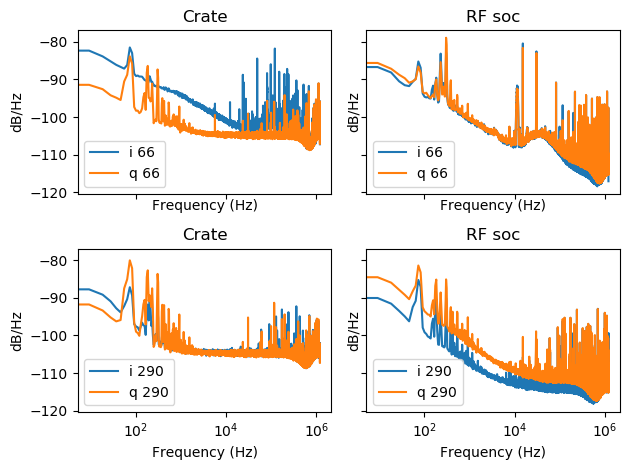

In [13]:
def TESTwelch_IQ(iq, fs, fig, ax, plot=True, welch_nperseg=2**18, title='', ch=None):
    i = iq.real
    q = iq.imag
    ffi, pxxi = welch(i,fs=fs, nperseg=welch_nperseg)
    ffq, pxxq = welch(q,fs=fs, nperseg=welch_nperseg)

    # scale to dBc/Hz by the voltage magnitude
    #magfac = np.mean(q)**2 + np.mean(i)**2
    pxxi_db = 10. * np.log10(pxxi)# / magfac)
    pxxq_db = 10. * np.log10(pxxq)# / magfac)


    if plot:
        ax.semilogx(ffi,pxxi_db,linestyle='-',label=f'i {ch}', color='C0')
        ax.semilogx(ffq,pxxq_db, linestyle='-',label=f'q {ch}', color='C1')
        ax.set_ylabel('dB/Hz')
        ax.set_xlabel('Frequency (Hz)')
        ax.set_title(title)
        ax.legend(loc='lower left')
    return
# these files are from the crate :
logfile_crate = '/data/smurf_data/20250624/1750806949/outputs/1750806949.log'
directory_path_crate = '/data/smurf_data/20250624/1750806949/outputs/'
crate_tune_file = '/data/smurf_data/tune/1750808478_tune.npy'
crate_file_list =  ['1750808504_single_channel_b2ch066', '1750808528_single_channel_b2ch290']


logfile = '/data/smurf_data/20250626/1750957495/outputs/1750957495.log'
directory_path_rfsoc = '/data/smurf_data/20250626/1750957495/outputs/'
rfsoc_tune_file = '/data/smurf_data/tune/1751048683_tune.npy'
rfsoc_file_list =  ['1751048723_single_channel_b2ch066', '1751048750_single_channel_b2ch290']

fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
for e, file in enumerate(crate_file_list): 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_crate+file+'.dat')
    n_subbands = S.get_number_sub_bands()
    digitizer_frequency_mhz = S.get_digitizer_frequency_mhz()
    subband_half_width_mhz = (digitizer_frequency_mhz / n_subbands)
    i = i / subband_half_width_mhz
    q = q / (-1* subband_half_width_mhz)
    fs = 2.4e6
    if e%2 == 0: 
        channel = 66
    else: channel = 290
    TESTwelch_IQ(i+1j*q, fs=fs,welch_nperseg=2**18, fig=fig, ax=axs[ e, 0],title='Crate', ch=channel,plot=True)

for e, file in enumerate(rfsoc_file_list): 
    #load file 
    i, q, _ = S.decode_single_channel(directory_path_rfsoc+file+'.dat')
    n_subbands = S.get_number_sub_bands()
    digitizer_frequency_mhz = S.get_digitizer_frequency_mhz()
    subband_half_width_mhz = (digitizer_frequency_mhz / n_subbands)
    i = i / subband_half_width_mhz
    q = q / (-1* subband_half_width_mhz)
    fs = 2.4e6
    if e%2 == 0: 
        channel = 66
    else: channel = 290
    TESTwelch_IQ(i+1j*q, fs=fs,welch_nperseg=2**18, fig=fig, ax=axs[ e, 1],title='RF soc', ch=channel,plot=True)



plt.tight_layout()